In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections

In [2]:
class Turtle:
    def __init__(self, direction=0):
        self.history = [(0,0)]
        self.step_history = []
        self.direction = direction

    def forward(self, step_size):
        old = self.history[-1]
        new = (
            old[0] + step_size * np.cos(self.direction),
            old[1] + step_size * np.sin(self.direction),
        )
        self.history.append(new)
        self.step_history.append((step_size, self.direction))

    def _rotate(self, angle):
        self.direction += angle * np.pi / 180

    def left(self, angle):
        self._rotate(+angle)

    def right(self, angle):
        self._rotate(-angle)


In [3]:
GOSPER_HISTORY = []

def gosper_curve(turtle, order: int, size: int, is_A: bool = True, limit=1e5, parity=+1) -> None:
    """Draw the Gosper curve."""
    GOSPER_HISTORY.append((order, size, is_A, limit))
    if limit < 0:
        return turtle
    if order == 0:
        turtle.forward(size)
        return turtle
    if is_A:
        next_movements = "A-B--B+A++AA+B-"
    else:
        next_movements = "+A-BB--B-A++A+B"
    for op in next_movements:
        limit -= 1
        if op == "A":
            turtle = gosper_curve(turtle, order=order-1, size=size, is_A=True, limit=limit, parity=parity)
        elif op == "B":
            turtle = gosper_curve(turtle, order=order-1, size=size, is_A=False, limit=limit, parity=parity)
        elif op == "+":
            turtle.right(60 * parity)
        elif op == "-":
            turtle.left(60 * parity)
    return turtle


In [4]:
len("A-B--B+A++AA+B-"), len("+A-BB--B-A++A+B")

(15, 15)

In [5]:
t = gosper_curve(Turtle(), order=8, size=1, limit=1e6)

In [6]:
len(t.history), len(GOSPER_HISTORY)

(5764802, 6725601)

In [7]:
GOSPER_HISTORY[-10:]

[(0, 1, True, 999886.0),
 (0, 1, False, 999884.0),
 (1, 1, False, 999896.0),
 (0, 1, True, 999894.0),
 (0, 1, False, 999892.0),
 (0, 1, False, 999891.0),
 (0, 1, False, 999888.0),
 (0, 1, True, 999886.0),
 (0, 1, True, 999883.0),
 (0, 1, False, 999881.0)]

In [8]:
min([x[3]-1e6 for x in GOSPER_HISTORY])

-119.0

In [9]:
import collections
collections.Counter([x[0] for x in GOSPER_HISTORY]).most_common()

[(0, 5764801),
 (1, 823543),
 (2, 117649),
 (3, 16807),
 (4, 2401),
 (5, 343),
 (6, 49),
 (7, 7),
 (8, 1)]

In [10]:
collections.Counter([x[2] for x in GOSPER_HISTORY]).most_common()

[(True, 3362805), (False, 3362796)]

In [11]:
[7**x for x in range(10)]

[1, 7, 49, 343, 2401, 16807, 117649, 823543, 5764801, 40353607]

In [12]:
t.history[-10:]

[(-2140.000000000001, 1098.120211998558),
 (-2139.000000000001, 1098.120211998558),
 (-2138.500000000001, 1097.2541865947735),
 (-2139.000000000001, 1096.388161190989),
 (-2138.500000000001, 1095.5221357872044),
 (-2138.000000000001, 1094.65611038342),
 (-2137.500000000001, 1095.5221357872044),
 (-2138.000000000001, 1096.388161190989),
 (-2137.000000000001, 1096.388161190989),
 (-2136.500000000001, 1095.5221357872044)]

In [13]:
t.history[:10]

[(0, 0),
 (1.0, 0.0),
 (1.5, 0.8660254037844386),
 (0.5, 0.8660254037844387),
 (-2.220446049250313e-16, 1.7320508075688772),
 (0.9999999999999998, 1.7320508075688776),
 (1.9999999999999998, 1.732050807568878),
 (2.5, 0.8660254037844397),
 (3.5, 0.8660254037844402),
 (3.9999999999999996, 1.732050807568879)]

In [14]:
vec = np.array(t.history)

In [15]:
vec

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 1.50000000e+00,  8.66025404e-01],
       ...,
       [-2.13800000e+03,  1.09638816e+03],
       [-2.13700000e+03,  1.09638816e+03],
       [-2.13650000e+03,  1.09552214e+03]])

In [16]:
class TransformerLikeH3:
    MATRIX_IJK = np.array([[1, -0.5, -0.5], [0, np.sqrt(3)/2, -np.sqrt(3)/2]])
    MATRIX_D = np.array([[1, -0.5, -0.5], [-0.5, 1, -0.5]])
    
    def __init__(self, scale_factor=1.0, rotation_angle=0.0):
        self.scale_factor = scale_factor
        self.rotation_angle = rotation_angle * np.pi / 180

    def _rotate(self, coords, inverse=False):
        cos_ = np.cos(self.rotation_angle)
        sin_ = np.sin(self.rotation_angle)
        if inverse:
            sin_ *= -1
        mat_rotate = np.array([[cos_, -sin_], [sin_, cos_]])
        return np.dot(coords, mat_rotate)
    
    def _scale(self, coords, inverse=False):
        factor = self.scale_factor
        if inverse:
            factor = 1 / factor
        return coords / factor
        
    def _to_cell(self, coords):
        coords_ijk = np.dot(coords, self.MATRIX_IJK)
        disp = np.zeros((coords_ijk.shape[0], 2))
        plan_ = [
            (lambda v: np.floor(v[:, 0] + 0.5), np.array([+1,0])),
            (lambda v: np.floor(v[:, 1] + 0.5), np.array([0,+1])),
            (lambda v: np.floor(v[:, 2] + 0.5), np.array([-1,-1])),
        ]
        while True:
            should_break = True
            for plan in plan_:
                change = plan[0](coords_ijk)
                if abs(change).sum() > 0:
                    should_break = False
                new_disp = np.outer(change, plan[1])
                disp += new_disp
                coords_ijk -= np.dot(new_disp, self.MATRIX_D)
            if should_break:
                break
        cell_coordinates = np.zeros((coords.shape[0], 3))
        cell_coordinates[:, :2] = disp
        min_ = cell_coordinates.min(axis=1)
        change = - np.minimum(0, min_)
        cell_coordinates += np.outer(change, np.array([1,1,1]))
        return cell_coordinates        

    def transform(self, coords):
        coords_ = self._scale(coords)
        coords_ = self._rotate(coords_)
        cells = self._to_cell(coords_)
        return cells

    def inverse_transform(self, cells):
        center = np.dot(cells, self.MATRIX_IJK.T)
        center = self._rotate(center, inverse=True)
        center = self._scale(center, inverse=True)
        return center

        

In [17]:
transf = TransformerLikeH3(scale_factor=1, rotation_angle=0)
cells = transf.transform(vec)
centers = transf.inverse_transform(cells)

In [18]:
cells

array([[0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00],
       [2.000e+00, 1.000e+00, 0.000e+00],
       ...,
       [0.000e+00, 2.771e+03, 1.505e+03],
       [0.000e+00, 2.770e+03, 1.504e+03],
       [0.000e+00, 2.769e+03, 1.504e+03]])

In [19]:
diff = (vec - centers).round(15)
diff

array([[ 0.00000e+00,  0.00000e+00],
       [ 0.00000e+00,  0.00000e+00],
       [ 0.00000e+00,  0.00000e+00],
       ...,
       [-9.09000e-13, -1.10276e-10],
       [-9.09000e-13, -1.10049e-10],
       [-9.09000e-13, -1.10504e-10]])

In [20]:
diff.flatten().max(), diff.flatten().min()

(1.421e-12, -1.18462e-10)

In [21]:
cells

array([[0.000e+00, 0.000e+00, 0.000e+00],
       [1.000e+00, 0.000e+00, 0.000e+00],
       [2.000e+00, 1.000e+00, 0.000e+00],
       ...,
       [0.000e+00, 2.771e+03, 1.505e+03],
       [0.000e+00, 2.770e+03, 1.504e+03],
       [0.000e+00, 2.769e+03, 1.504e+03]])

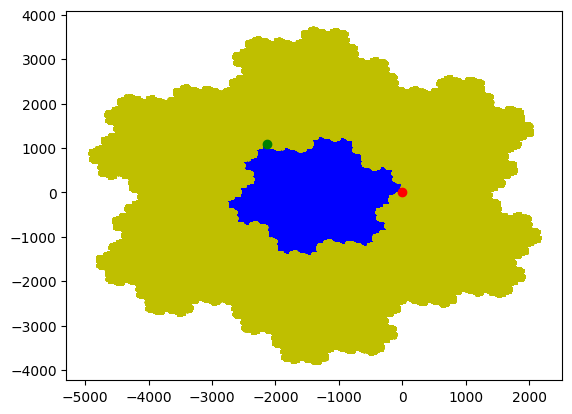

In [22]:
fig, ax = plt.subplots()
ax.scatter(vec[:, 0], vec[:, 1], s=1, color='b');
ax.plot(vec[0, 0], vec[0, 1], 'ro');
ax.plot(vec[-1, 0], vec[-1, 1], 'go');

# disp = vec[-1, :]
# ax.scatter(vec[:, 0] + disp[0], vec[:, 1] + disp[1], s=1, color='y');

for ang in [0, 60, 120, 180, 240, 300]:
    angle = ang * np.pi / 180
    rot_matrix = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
    disp = np.dot(vec[-1, :], rot_matrix)
    ax.scatter(vec[:, 0] + disp[0], vec[:, 1] + disp[1], s=1, color='y');


In [23]:
rot_matrix

array([[ 0.5      , -0.8660254],
       [ 0.8660254,  0.5      ]])

In [24]:
a = 5764802
b = 40353608

In [25]:
vec

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00],
       [ 1.50000000e+00,  8.66025404e-01],
       ...,
       [-2.13800000e+03,  1.09638816e+03],
       [-2.13700000e+03,  1.09638816e+03],
       [-2.13650000e+03,  1.09552214e+03]])

In [26]:
mean = vec.mean(axis=0)
cell_mean = transf.transform(mean.reshape(-1, 2))
print(cell_mean)
point_mean = transf.inverse_transform(cell_mean)
print(mean, point_mean)

[[   0. 1345. 1424.]]
[-1384.49989028   -68.9931432 ] [[-1384.5         -68.4160069]]


In [27]:
len(vec)

5764802

In [28]:
vec[len(vec)//2]

array([-673.       , -434.7447527])

In [29]:
mn = ((vec - point_mean)**2).sum(axis=1).argmin()
vec[mn]- point_mean

array([[-9.09494702e-13, -5.20685717e-11]])

In [30]:
round(mn / len(vec), 5)

0.375

In [31]:
(3/8 - 2/7) * 7

0.6250000000000001

In [32]:
2/7 + (5/56)

0.375

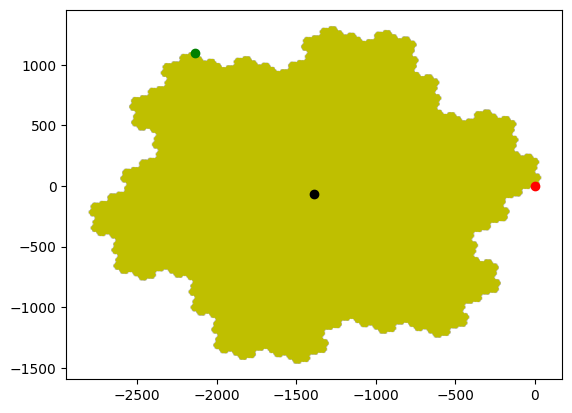

In [33]:
fig, ax = plt.subplots()
ax.scatter(vec[:, 0], vec[:, 1], s=1, color='y', alpha=0.01);
ax.plot(vec[0, 0], vec[0, 1], 'ro');
ax.plot(vec[-1, 0], vec[-1, 1], 'go');

point_mean = transf.inverse_transform(transf.transform(vec.mean(axis=0).reshape(-1, 2)))
ax.plot(point_mean[-1, 0], point_mean[-1, 1], 'ko');



In [34]:
da = vec[0, :] - point_mean[0]
db = vec[-1, :] - point_mean[0]

In [35]:
np.arctan2(da[1], da[0]) * 180/np.pi

2.829008590595297

In [36]:
np.arctan2(db[1], db[0]) * 180/np.pi

122.86579277662506

In [37]:
point_mean[0]

array([-1384.5      ,   -68.4160069])

## Recursiveness

In [38]:
curves = {
    ord_: gosper_curve(Turtle(), order=ord_, size=1, limit=1e6)
    for ord_ in range(0, 9)
}

In [39]:
[(x, len(y.history), len(y.history)-7**x-1) for x, y in curves.items()]

[(0, 2, 0),
 (1, 8, 0),
 (2, 50, 0),
 (3, 344, 0),
 (4, 2402, 0),
 (5, 16808, 0),
 (6, 117650, 0),
 (7, 823544, 0),
 (8, 5764802, 0)]

In [40]:
df_curves = [
    (
        pd.DataFrame(y.history, columns=['X_ord{}'.format(x), 'Y_ord{}'.format(x)])
        .round(10)
        .reset_index()
    )
    for x, y in curves.items()
]
df_curve = df_curves[0]
for df in df_curves[1:]:
    df_curve = df_curve.merge(df, on=['index'], how='outer')

In [41]:
def compare(df, indexA, indexB):
    dfout = df.assign(
        diffX=lambda df: df['X_ord{}'.format(indexB)] - df['X_ord{}'.format(indexA)],
        diffY=lambda df: df['Y_ord{}'.format(indexB)] - df['Y_ord{}'.format(indexA)],
    )[['diffX', 'diffY']].dropna()
    return dfout

In [42]:
dfcomp = compare(df_curve, 7, 8)

In [43]:
dfcomp.describe()

,diffX,diffY
count,823544.0,823544.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


In [44]:
flter_ = (abs(df_curve['X_ord8'])<1e-3) & (abs(df_curve['Y_ord8'])<1e-3)
df_curve[flter_]

,index,X_ord0,Y_ord0,X_ord1,Y_ord1,X_ord2,Y_ord2,X_ord3,Y_ord3,X_ord4,Y_ord4,X_ord5,Y_ord5,X_ord6,Y_ord6,X_ord7,Y_ord7,X_ord8,Y_ord8
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
df_curve.iloc[-1] / np.sqrt(7)

index     2.178890e+06
X_ord0             NaN
Y_ord0             NaN
X_ord1             NaN
Y_ord1             NaN
X_ord2             NaN
Y_ord2             NaN
X_ord3             NaN
Y_ord3             NaN
X_ord4             NaN
Y_ord4             NaN
X_ord5             NaN
Y_ord5             NaN
X_ord6             NaN
Y_ord6             NaN
X_ord7             NaN
Y_ord7             NaN
X_ord8   -8.075211e+02
Y_ord8    4.140684e+02
Name: 5764801, dtype: float64

In [46]:
boundaries = {x: (y.history[0], y.history[-1]) for x, y in curves.items()}

In [47]:
def get_size_and_angle(pt0, pt1):
    diffX = pt1[0] - pt0[0]
    diffY = pt1[1] - pt0[1]
    size = np.sqrt(diffX**2 + diffY**2)
    angle = np.arctan2(diffY, diffX) * 180/np.pi
    return round(size, 8), round(angle, 8)

In [48]:
size_angle = {x: get_size_and_angle(*y) for x,y in boundaries.items()}

In [49]:
size_angle

{0: (1.0, 0.0),
 1: (2.64575131, 19.10660535),
 2: (7.0, 38.2132107),
 3: (18.52025918, 57.31981605),
 4: (49.0, 76.4264214),
 5: (129.64181424, 95.53302675),
 6: (343.0, 114.63963211),
 7: (907.4926997, 133.74623746),
 8: (2401.0, 152.85284281)}

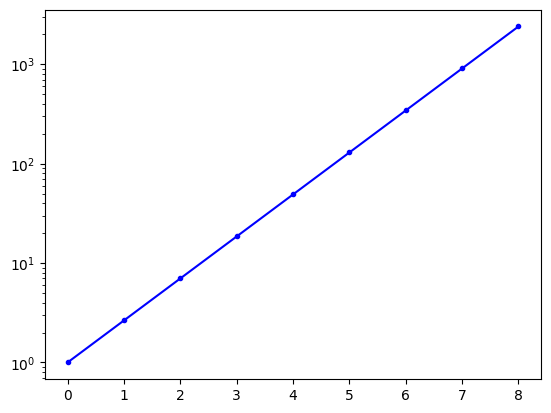

In [50]:
fig, ax = plt.subplots()
plot_pts = [(x, y[0]) for x, y in size_angle.items()]
ax.plot([x[0] for x in plot_pts], [x[1] for x in plot_pts], 'b.-');
# ax.set_xscale('log');
ax.set_yscale('log');


[ 1.91066054e+01 -2.66668519e-09]


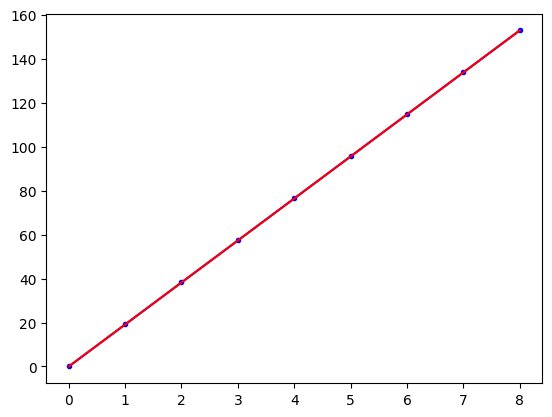

In [51]:
fig, ax = plt.subplots()
plot_pts = [(x, y[1]) for x, y in size_angle.items()]
ax.plot([x[0] for x in plot_pts], [x[1] for x in plot_pts], 'b.-');
fit = np.polyfit([x[0] for x in plot_pts], [x[1] for x in plot_pts], 1)
poly = np.poly1d(fit)
print(fit)
ax.plot([x[0] for x in plot_pts], [poly(x[0]) for x in plot_pts], 'r-');


In [52]:
ANGLE_DISPLACEMENT = fit[0]
ANGLE_DISPLACEMENT

19.1066053515

In [53]:
[(x, round(y[0] / 7**(x/2), 8), round(y[1]-x*ANGLE_DISPLACEMENT, 10)) for x, y in size_angle.items()]

[(0, 1.0, 0.0),
 (1, 1.0, -1.5e-09),
 (2, 1.0, -3e-09),
 (3, 1.0, -4.5e-09),
 (4, 1.0, -6e-09),
 (5, 1.0, -7.5e-09),
 (6, 1.0, 1e-09),
 (7, 1.0, -5e-10),
 (8, 1.0, -2e-09)]

In [54]:
360 / ANGLE_DISPLACEMENT

18.841651532397275

50


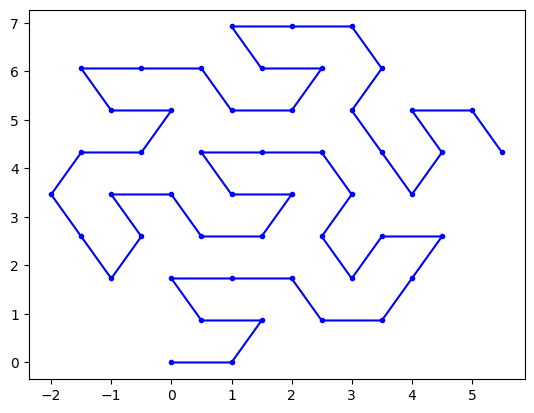

In [55]:
fig, ax = plt.subplots()
plot_pts = curves[2].history
print(len(plot_pts))
ax.plot([x[0] for x in plot_pts], [x[1] for x in plot_pts], 'b.-');


50


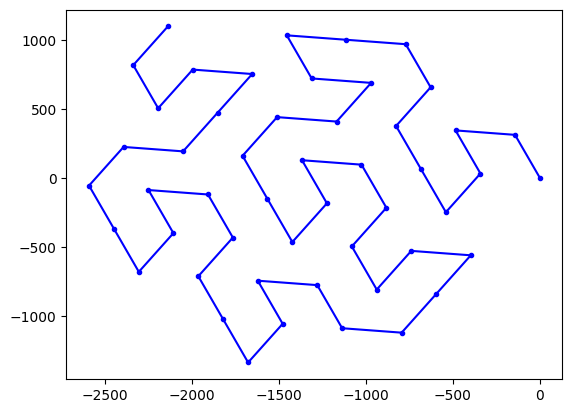

In [56]:
fig, ax = plt.subplots()
plot_pts = curves[8].history[::7**6]
print(len(plot_pts))
ax.plot([x[0] for x in plot_pts], [x[1] for x in plot_pts], 'b.-');

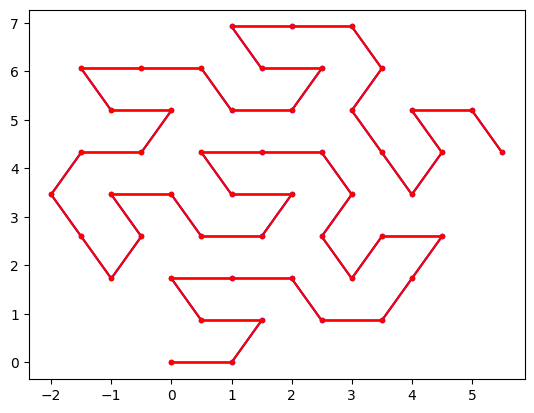

In [57]:
fig, ax = plt.subplots()
plot_pts = curves[2].history
plot_x = np.array([x[0] for x in plot_pts])
plot_y = np.array([x[1] for x in plot_pts])
ax.plot(plot_x, plot_y, 'b.-');
plot_pts = curves[8].history[::7**6]
scale = 7**(6/2)
plot_x = np.array([x[0] for x in plot_pts]) / scale
plot_y = np.array([x[1] for x in plot_pts]) / scale
angle = -(6*ANGLE_DISPLACEMENT) * np.pi/180
plot_xx = plot_x * np.cos(angle) - plot_y * np.sin(angle)
plot_yy = plot_x * np.sin(angle) + plot_y * np.cos(angle)
# ax.plot(plot_x, plot_y, 'g.-');
ax.plot(plot_xx, plot_yy, 'r.-');


In [58]:
ANGLE_DISPLACEMENT

19.1066053515

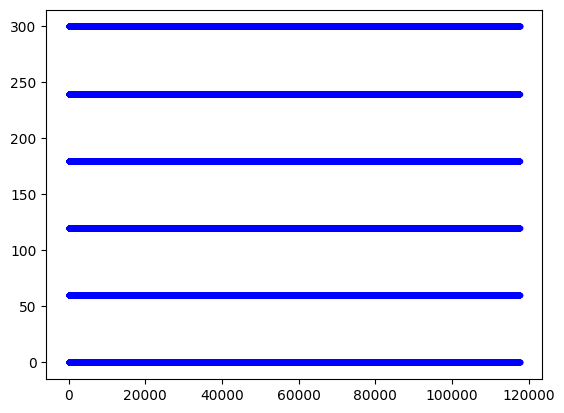

In [59]:
fig, ax = plt.subplots()
plot_pts = [(i, round(x[1]*180/np.pi, 5)%360) for i, x in enumerate(curves[6].step_history)]
ax.plot([x[0] for x in plot_pts], [x[1] for x in plot_pts], 'b.');


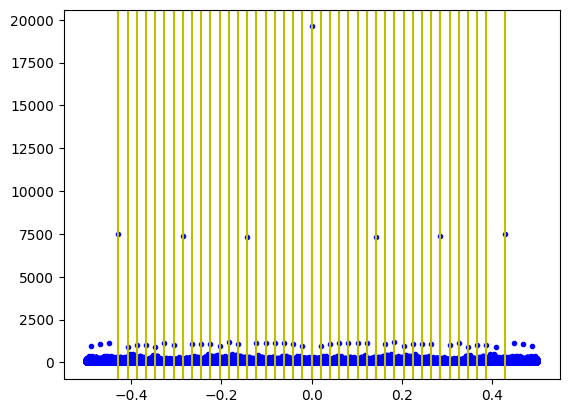

In [60]:
equal_0 = [1 if abs(x[1]-60)<1e-3 else 0 for x in plot_pts[:]]
fft_0 = np.fft.fft(equal_0)
fft_f = np.fft.fftfreq(len(equal_0))
fig, ax = plt.subplots()
ax.plot(fft_f, abs(fft_0), 'b.');
for i in range(-3, 4):
    ax.axvline(i/7, color='y');
for i in range(-20, 20):
    ax.axvline(i/49, color='y');


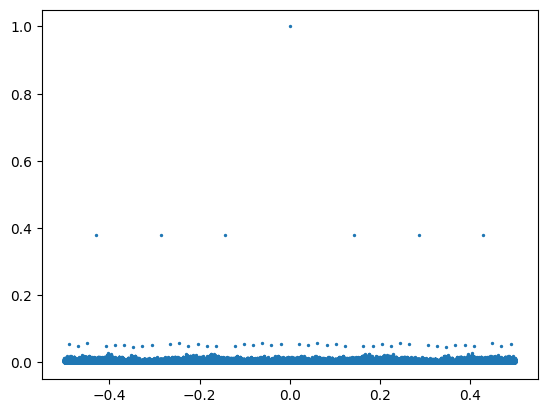

In [61]:
equal_0 = [1 if abs(x[1]-0)<1e-3 else 0 for x in plot_pts[:]]
fft_0 = np.fft.fft(equal_0)
fft_f = np.fft.fftfreq(len(equal_0))
fig, ax = plt.subplots()
# ax.scatter(fft_f, np.real(fft_0), s=2);
# ax.scatter(fft_f, np.imag(fft_0), s=2);
ax.scatter(fft_f, np.abs(fft_0) / max(np.abs(fft_0)), s=2);


<AxesSubplot: ylabel='Frequency'>

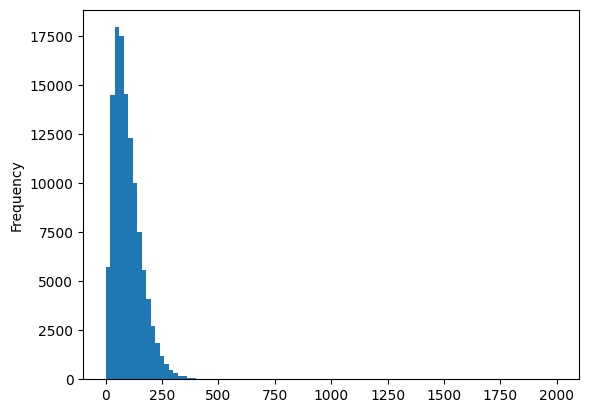

In [62]:
pd.Series(np.abs(fft_0)).clip(upper=2000).plot.hist(bins=100)

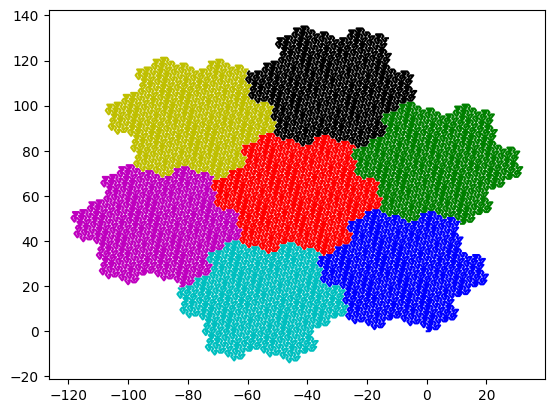

In [63]:
fig, ax = plt.subplots()
plot_pts = curves[5].history
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
size = len(plot_pts) // 7
for i, color in zip(range(7), colors):
    plot_pts_this = [x for ct, x in enumerate(plot_pts) if ct//size==i]
    plot_x = np.array([x[0] for x in plot_pts_this])
    plot_y = np.array([x[1] for x in plot_pts_this])
    ax.plot(plot_x, plot_y, color+'-');


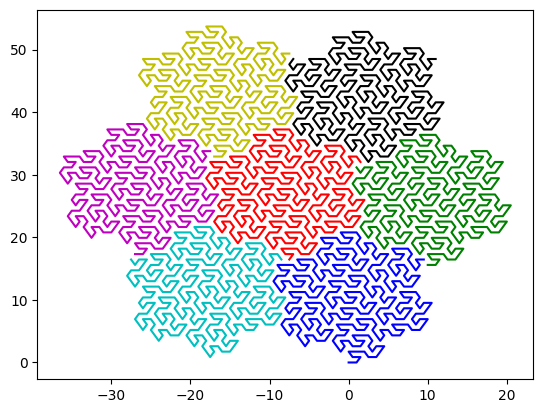

In [64]:
fig, ax = plt.subplots()
plot_pts = curves[4].history
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
size = len(plot_pts) // 7
for i, color in zip(range(7), colors):
    plot_pts_this = [x for ct, x in enumerate(plot_pts) if ct//size==i]
    plot_x = np.array([x[0] for x in plot_pts_this])
    plot_y = np.array([x[1] for x in plot_pts_this])
    ax.plot(plot_x, plot_y, color+'-');

## As string

In [65]:
def instructions_gosper_curve(order: int) -> str:
    def _up_one_order(instructions: str) -> str:
        replace = {
            "A": "A-B--B+A++AA+B-",
            "B": "+A-BB--B-A++A+B",
        }
        new_instructions = [replace.get(x, x) for x in instructions]
        return ''.join(new_instructions)
    instructions = "A"
    for _ in range(order):
        instructions = _up_one_order(instructions)
    return instructions

In [66]:
ins_curves = {x: instructions_gosper_curve(x) for x in range(0, 11)}

In [67]:
[(x, len(y)) for x, y in ins_curves.items()]

[(0, 1),
 (1, 15),
 (2, 113),
 (3, 799),
 (4, 5601),
 (5, 39215),
 (6, 274513),
 (7, 1921599),
 (8, 13451201),
 (9, 94158415),
 (10, 659108913)]

In [68]:
df_instructions = pd.pivot_table(
    pd.concat([
        pd.DataFrame(collections.Counter(y).most_common(), columns=['instruction', 'count']).assign(order_=x)
        for x, y in ins_curves.items() if x>=1
    ]),
    index=['order_'],
    columns=['instruction'],
    values='count',
)

In [69]:
df_instructions 

instruction,+,-,A,B
order_,,,,
1,4,4,4,3
2,32,32,25,24
3,228,228,172,171
4,1600,1600,1201,1200
5,11204,11204,8404,8403
6,78432,78432,58825,58824
7,549028,549028,411772,411771
8,3843200,3843200,2882401,2882400
9,26902404,26902404,20176804,20176803


In [70]:
df_instructions['total'] = df_instructions[['+', '-', 'A', 'B']].sum(axis=1)
df_instructions['power_of_7'] = df_instructions.index.map(lambda x: 7**x)
for col in ['+', '-', 'A', 'B', 'total']:
    df_instructions[col+'_normalized'] = df_instructions[col] / df_instructions['power_of_7']
df_instructions

instruction,+,-,A,B,total,power_of_7,+_normalized,-_normalized,A_normalized,B_normalized,total_normalized
order_,,,,,,,,,,,
1,4,4,4,3,15,7,0.571429,0.571429,0.571429,0.428571,2.142857
2,32,32,25,24,113,49,0.653061,0.653061,0.510204,0.489796,2.306122
3,228,228,172,171,799,343,0.664723,0.664723,0.501458,0.498542,2.329446
4,1600,1600,1201,1200,5601,2401,0.666389,0.666389,0.500208,0.499792,2.332778
5,11204,11204,8404,8403,39215,16807,0.666627,0.666627,0.500030,0.499970,2.333254
6,78432,78432,58825,58824,274513,117649,0.666661,0.666661,0.500004,0.499996,2.333322
7,549028,549028,411772,411771,1921599,823543,0.666666,0.666666,0.500001,0.499999,2.333332
8,3843200,3843200,2882401,2882400,13451201,5764801,0.666667,0.666667,0.500000,0.500000,2.333333
9,26902404,26902404,20176804,20176803,94158415,40353607,0.666667,0.666667,0.500000,0.500000,2.333333


In [71]:
df_instructions['+'] - df_instructions['-']

order_
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64

In [72]:
df_instructions['A'] - df_instructions['B']

order_
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
dtype: int64

In [73]:
df_instructions['A'] + df_instructions['B'] - df_instructions['power_of_7']

order_
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64

In [74]:
df_instructions['+'] - df_instructions['-']

order_
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
dtype: int64

In [75]:
df_instructions['+'] - df_instructions['power_of_7']*2/3

order_
1    -0.666667
2    -0.666667
3    -0.666667
4    -0.666667
5    -0.666667
6    -0.666667
7    -0.666667
8    -0.666667
9    -0.666667
10   -0.666667
dtype: float64

In [76]:
(df_instructions['power_of_7']-1).apply(lambda x: x%6)

order_
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
Name: power_of_7, dtype: int64

In [77]:
def list_of_steps(instructions):
    steps = []
    step = 0
    for ins_ in instructions:
        if ins_ in ['A', 'B']:
            steps.append(step)
        elif ins_ in ['+']:
            step = (step + 1) % 6
        elif ins_ in ['-']:
            step = (step - 1) % 6
    return ''.join([str(x) for x in steps])



In [78]:
steps = list_of_steps(ins_curves[6])

In [79]:
steps

'053400105532454331023431244505340010534001211540105340010553245055324543310232150223431244505532454312445433102343310232115401053400121502234331023431244543310232115401215022343124454312445055324505340010553245433102343124450534001053400121154010534001055324543310234312445053400105340012115401215022321154012115401055324543124450534001211540105340010553245433102343124450534001053400121154010534001055324505532454331023215022343124450553245053400105532450553245433102321502234312445055324543124454331023433102321154010534001215022343310232150223211540105532450534001215022321502234331023431244543310232115401215022343124454312445055324505340010553245055324543310232150223431244505532454312445433102321154012150223431244543124450553245431244543310234331023211540105340012150223433102343124454331023433102321154010534001215022343310232150223211540121154010553245431244505340012115401053400105532454331023431244505340010534001211540121502232115401055324505340012150223215022343310234312445433102343310

In [80]:
collections.Counter(steps)

Counter({'0': 19513,
         '5': 19608,
         '3': 19608,
         '4': 19836,
         '1': 19608,
         '2': 19476})

In [81]:
df_steps = pd.pivot_table(
    pd.concat([
        pd.DataFrame(collections.Counter(list_of_steps(y)).most_common(), columns=['direction', 'count']).assign(order_=x)
        for x, y in ins_curves.items() if x>=1 and x<=9
    ]),
    index=['order_'],
    columns=['direction'],
    values='count',
).fillna(0).astype(int)

In [82]:
cols = ['0', '1', '2', '3', '4', '5']
df_steps['total'] = df_steps[cols].sum(axis=1)
df_steps['power_of_7'] = df_steps.index.map(lambda x: 7**x)
for col in cols+['total']:
    df_steps[col+'_normalized'] = df_steps[col] / df_steps['power_of_7']
df_steps

direction,0,1,2,3,4,5,total,power_of_7,0_normalized,1_normalized,2_normalized,3_normalized,4_normalized,5_normalized,total_normalized
order_,,,,,,,,,,,,,,,
1,3,1,0,1,1,1,7,7,0.428571,0.142857,0.000000,0.142857,0.142857,0.142857,1.0
2,12,8,4,8,9,8,49,49,0.244898,0.163265,0.081633,0.163265,0.183673,0.163265,1.0
3,64,57,45,57,63,57,343,343,0.186589,0.166181,0.131195,0.166181,0.183673,0.166181,1.0
4,408,400,369,400,424,400,2401,2401,0.169929,0.166597,0.153686,0.166597,0.176593,0.166597,1.0
5,2793,2801,2731,2801,2880,2801,16807,16807,0.166181,0.166657,0.162492,0.166657,0.171357,0.166657,1.0
6,19513,19608,19476,19608,19836,19608,117649,117649,0.165858,0.166665,0.165543,0.166665,0.168603,0.166665,1.0
7,136839,137257,137088,137257,137845,137257,823543,823543,0.166159,0.166666,0.166461,0.166666,0.167380,0.166666,1.0
8,959376,960800,960880,960800,962145,960800,5764801,5764801,0.166420,0.166667,0.166681,0.166667,0.166900,0.166667,1.0
9,6721408,6725601,6727185,6725601,6728211,6725601,40353607,40353607,0.166563,0.166667,0.166706,0.166667,0.166731,0.166667,1.0


In [83]:
for col in cols:
    df_steps[col+'_extra'] = df_steps[col] - ((df_steps['power_of_7']-1) / 6)
df_steps.filter(regex='extra')

direction,0_extra,1_extra,2_extra,3_extra,4_extra,5_extra
order_,,,,,,
1,2.0,0.0,-1.0,0.0,0.0,0.0
2,4.0,0.0,-4.0,0.0,1.0,0.0
3,7.0,0.0,-12.0,0.0,6.0,0.0
4,8.0,0.0,-31.0,0.0,24.0,0.0
5,-8.0,0.0,-70.0,0.0,79.0,0.0
6,-95.0,0.0,-132.0,0.0,228.0,0.0
7,-418.0,0.0,-169.0,0.0,588.0,0.0
8,-1424.0,0.0,80.0,0.0,1345.0,0.0
9,-4193.0,0.0,1584.0,0.0,2610.0,0.0


In [84]:
arg = (df_steps['4_extra'] - 1) / df_steps.index.map(lambda x: 2*np.sqrt(7**x))
np.arcsin(arg)

order_
1   -0.190126
2    0.000000
3    0.135401
4    0.236904
5    0.305562
6    0.337261
7    0.329340
8    0.283673
9    0.206825
dtype: float64

In [85]:
(np.arccos(0.5/np.sqrt(7)) - np.pi/3) * 180/np.pi

19.106605350869103

In [86]:
(np.arccos(-1/7)/2 - np.pi/6) * 180/np.pi

19.1066053508691

In [87]:
(np.arcsin(1/7)/2 + np.pi/12) * 180/np.pi

19.106605350869092

In [88]:
((1/7)/2 + np.pi/12) * 180/np.pi

19.09255567950588

In [89]:
(-np.arcsin(1/(2*np.sqrt(7))) + np.pi/6) * 180/np.pi

19.106605350869092

In [90]:
((1/3)*np.arcsin(17/(14*np.sqrt(7))) + np.pi/18) * 180/np.pi

19.106605350869092

In [91]:
((1/4)*np.arcsin(71/98) + np.pi/24) * 180/np.pi

19.1066053508691

In [92]:
(np.arccos(0.5/np.sqrt(7)) - np.pi/3) * 180/np.pi

19.106605350869103

In [93]:
ANGLE_DISPLACEMENT = 19.106605350869092 * np.pi/180

In [94]:
df_steps.index.map(lambda x: round(np.sqrt(7**x)*np.cos(x*ANGLE_DISPLACEMENT)*2/3 + 1/3, 5))

Float64Index([2.0, 4.0, 7.0, 8.0, -8.0, -95.0, -418.0, -1424.0, -4193.0], dtype='float64', name='order_')

In [95]:
vector_X = np.array([2, 1, -1, -2, -1, 1])/2
vector_Y = np.array([0, 1, 1, 0, -1, -1])*np.sqrt(3)/2
disp = [
    (i, np.dot(row.values, vector_X), np.dot(row.values, vector_Y))
    for i, row in df_steps[cols].iterrows()
]
disp

[(1, 2.5, -0.8660254037844386),
 (2, 5.5, -4.330127018922192),
 (3, 10.0, -15.588457268119885),
 (4, 11.5, -47.631397208144094),
 (5, -12.5, -129.03778516388093),
 (6, -143.0, -311.7691453624028),
 (7, -627.5, -655.581230664802),
 (8, -2136.5, -1095.5221357873074),
 (9, -6290.0, -888.5420642829629)]

In [96]:
ch = [np.sqrt(x[1]**2 + x[2]**2) / np.sqrt(7**x[0]) for x in disp]
ch

[1.0,
 0.9999999999999999,
 0.9999999999999994,
 0.9999999999999992,
 0.9999999999999967,
 1.0000000000000129,
 0.9999999999999856,
 0.9999999999999984,
 1.0000000000000029]

In [97]:
ch = [np.arctan2(x[2], x[1])*180/np.pi + 19.1066*0*x[0] for x in disp]
ch

[-19.106605350869092,
 -38.213210701738184,
 -57.31981605260728,
 -76.42642140347637,
 -95.53302675434549,
 -114.63963210521425,
 -133.74623745608446,
 -152.85284280695294,
 -171.9594481578207]

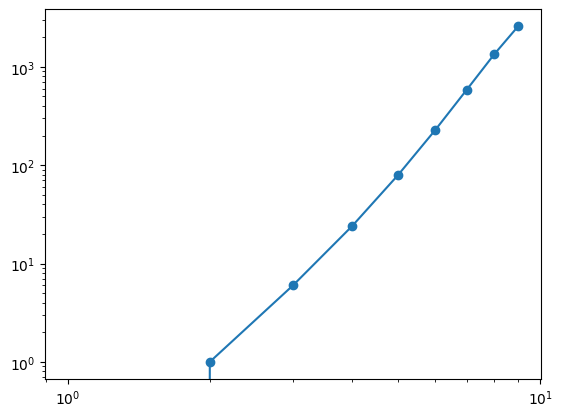

In [98]:
fig, ax = plt.subplots()
ax.plot(df_steps.index, df_steps['4_extra'], 'o-');
ax.set_yscale('log');
ax.set_xscale('log');


In [99]:
vector_X = (
    df_steps['0'] * (+1)
    + df_steps['1'] * (+1/2)
    + df_steps['2'] * (-1/2)
    + df_steps['3'] * (-1)
    + df_steps['4'] * (-1/2)
    + df_steps['5'] * (+1/2)
)
vector_Y = (
    df_steps['0'] * (0) * np.sqrt(3) / 2
    + df_steps['1'] * (+1) * np.sqrt(3) / 2
    + df_steps['2'] * (+1) * np.sqrt(3) / 2
    + df_steps['3'] * (0) * np.sqrt(3) / 2
    + df_steps['4'] * (-1) * np.sqrt(3) / 2
    + df_steps['5'] * (+1) * np.sqrt(3) / 2
)
vector_X, vector_Y

(order_
 1       2.5
 2       5.5
 3      10.0
 4      11.5
 5     -12.5
 6    -143.0
 7    -627.5
 8   -2136.5
 9   -6290.0
 dtype: float64,
 order_
 1    8.660254e-01
 2    9.526279e+00
 3    8.313844e+01
 4    6.451889e+02
 5    4.722437e+03
 6    3.365028e+04
 7    2.370805e+05
 8    1.663059e+06
 9    1.164819e+07
 dtype: float64)

In [100]:
vector = pd.concat([vector_X, vector_Y], axis=1)
vector.columns = ['X', 'Y']
vector.round(10)

,X,Y
order_,,
1,2.5,8.660254e-01
2,5.5,9.526279e+00
3,10.0,8.313844e+01
4,11.5,6.451889e+02
5,-12.5,4.722437e+03
6,-143.0,3.365028e+04
7,-627.5,2.370805e+05
8,-2136.5,1.663059e+06
9,-6290.0,1.164819e+07


In [101]:
list_of_steps(ins_curves[5])

'053400105532454331023431244505340010534001211540105340010553245055324543310232150223431244505532454312445433102343310232115401053400121502234331023431244543310232115401215022343124454312445055324505340010553245433102343124450534001053400121154010534001055324543310234312445053400105340012115401215022321154012115401055324543124450534001211540105340010553245433102343124450534001053400121154010534001055324505532454331023215022343124450553245053400105532450553245433102321502234312445055324543124454331023433102321154010534001215022343310232150223211540105532450534001215022321502234331023431244543310232115401215022343124454312445055324505340010553245055324543310232150223431244505532454312445433102321154012150223431244543124450553245431244543310234331023211540105340012150223433102343124454331023433102321154010534001215022343310232150223211540121154010553245431244505340012115401053400105532454331023431244505340010534001211540121502232115401055324505340012150223215022343310234312445433102343310

In [102]:
steps = list_of_steps(ins_curves[4])
print(len(steps)/7)
print(len(steps)/7**4)

343.0
1.0


In [103]:
sz = 7**3
print(steps[sz*0:sz*1])
print(steps[sz*1:sz*2])


0534001055324543310234312445053400105340012115401053400105532450553245433102321502234312445055324543124454331023433102321154010534001215022343310234312445433102321154012150223431244543124450553245053400105532454331023431244505340010534001211540105340010553245433102343124450534001053400121154012150223211540121154010553245431244505340012115401
0534001055324543310234312445053400105340012115401053400105532450553245433102321502234312445055324505340010553245055324543310232150223431244505532454312445433102343310232115401053400121502234331023215022321154010553245053400121502232150223433102343124454331023211540121502234312445431244505532450534001055324505532454331023215022343124450553245


In [104]:
a0 = steps[sz*0:sz*1]
a1 = steps[sz*1:sz*2]
collections.Counter([x==y for x, y in zip(a0, a1)])

Counter({True: 114, False: 229})

In [105]:
[x==y for x, y in zip(a0, a1)].index(False)

98

In [106]:
list_of_steps(ins_curves[1])

'0534001'

In [107]:
disp_vectors = {
    '0': +np.array([1, 0]),
    '1': +np.array([1/2, -np.sqrt(3)/2]),
    '2': +np.array([-1/2, -np.sqrt(3)/2]),
    '3': -np.array([1, 0]),
    '4': -np.array([1/2, -np.sqrt(3)/2]),
    '5': -np.array([-1/2, -np.sqrt(3)/2]),
}

In [108]:
steps = pd.DataFrame([[0,0]] + [list(disp_vectors[x]) for x in list_of_steps(ins_curves[1])])
steps.columns = ['step_X', 'step_Y']
steps['X'] = steps['step_X'].cumsum()
steps['Y'] = steps['step_Y'].cumsum()
steps

,step_X,step_Y,X,Y
0,0.0,0.000000,0.0,0.000000
1,1.0,0.000000,1.0,0.000000
2,0.5,0.866025,1.5,0.866025
3,-1.0,0.000000,0.5,0.866025
4,-0.5,0.866025,0.0,1.732051
5,1.0,0.000000,1.0,1.732051
6,1.0,0.000000,2.0,1.732051
7,0.5,-0.866025,2.5,0.866025


In [109]:
steps.iloc[:-1].mean()

step_X    0.285714
step_Y    0.247436
X         0.857143
Y         0.989743
dtype: float64

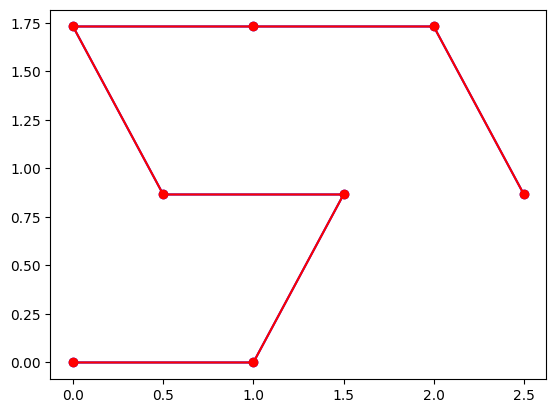

In [110]:
fig, ax = plt.subplots()
ax.plot(steps.iloc[:]['X'], steps.iloc[:]['Y'], 'bo-')

t = gosper_curve(Turtle(), order=1, size=1)
ax.plot([x[0] for x in t.history], [x[1] for x in t.history], 'ro-')


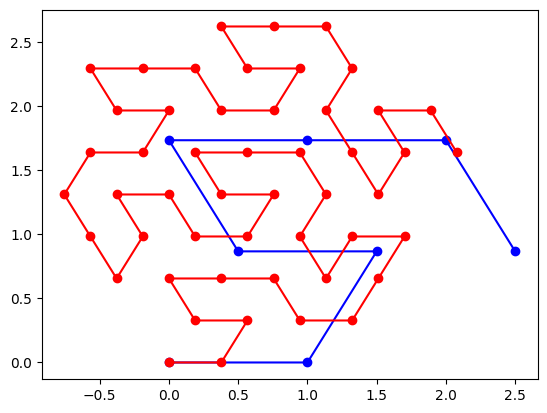

In [111]:
fig, ax = plt.subplots()

t = gosper_curve(Turtle(), order=1, size=1)
plot_x = np.array([x[0] for x in t.history])
plot_y = np.array([x[1] for x in t.history])
ax.plot(plot_x, plot_y, 'bo-')

t = gosper_curve(Turtle(), order=2, size=1)
plot_x = np.array([x[0] for x in t.history]) / np.sqrt(7)
plot_y = np.array([x[1] for x in t.history]) / np.sqrt(7)
ax.plot(plot_x, plot_y, 'ro-')

In [112]:
def get_hexagon(center, radius, angle):
    angle_rad = angle * np.pi / 180
    return [
        center + radius * np.array([np.cos(angle_rad + k * np.pi/3), np.sin(angle_rad + k * np.pi/3)])
        for k in range(7)
    ]

In [113]:
get_hexagon(np.array([0, 0]), 0.5, 0)

[array([0.5, 0. ]),
 array([0.25     , 0.4330127]),
 array([-0.25     ,  0.4330127]),
 array([-5.000000e-01,  6.123234e-17]),
 array([-0.25     , -0.4330127]),
 array([ 0.25     , -0.4330127]),
 array([ 5.0000000e-01, -1.2246468e-16])]

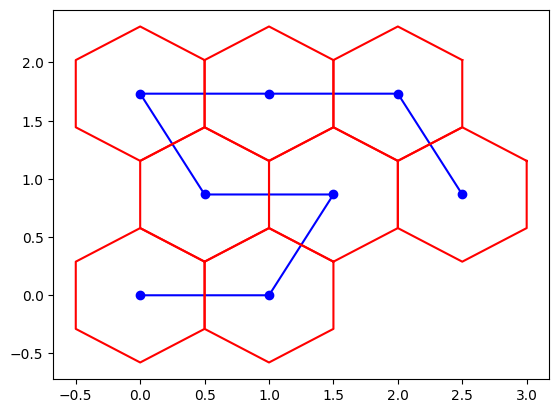

In [114]:
fig, ax = plt.subplots()

t = gosper_curve(Turtle(), order=1, size=1)
plot_x = np.array([x[0] for x in t.history])
plot_y = np.array([x[1] for x in t.history])
plot_xy = np.array([np.array([x[0], x[1]]) for x in t.history])
ax.plot(plot_x, plot_y, 'bo-')

for center in plot_xy:
    hex_ = get_hexagon(center, 1/np.sqrt(3), 30 * 1)
    ax.plot([x[0] for x in hex_], [x[1] for x in hex_], 'r-');


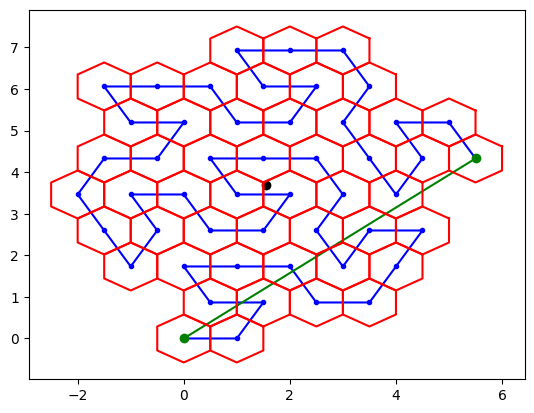

In [115]:
fig, ax = plt.subplots()

t = gosper_curve(Turtle(), order=2, size=1)
plot_x = np.array([x[0] for x in t.history])
plot_y = np.array([x[1] for x in t.history])
plot_xy = np.array([np.array([x[0], x[1]]) for x in t.history])
ax.plot(plot_x, plot_y, 'b.-')

ax.plot(plot_x[[0,-1]], plot_y[[0,-1]], 'go-')
ax.plot(plot_x.mean(), plot_y.mean(), 'ko-')

for center in plot_xy:
    hex_ = get_hexagon(center, 1/np.sqrt(3), 30 * 1)
    ax.plot([x[0] for x in hex_], [x[1] for x in hex_], 'r-');

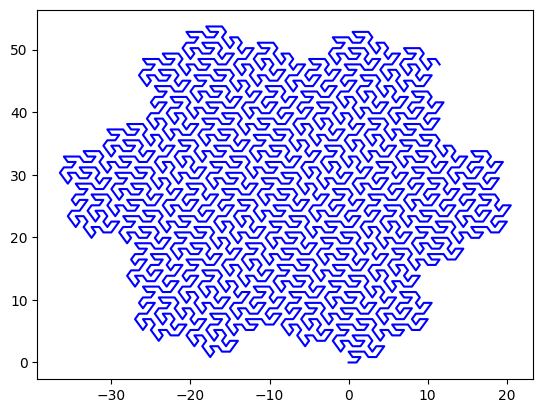

In [116]:
fig, ax = plt.subplots()

t = gosper_curve(Turtle(), order=4, size=1)
plot_x = np.array([x[0] for x in t.history])
plot_y = np.array([x[1] for x in t.history])
plot_xy = np.array([np.array([x[0], x[1]]) for x in t.history])
ax.plot(plot_x, plot_y, 'b-')

# for center in plot_xy:
#     hex_ = get_hexagon(center, 1/np.sqrt(3), 30 * 1)
#     ax.plot([x[0] for x in hex_], [x[1] for x in hex_], 'r-');

## The H3 ordering

In [118]:
from h3 import h3
RESOLUTION = 9
REPORTED_EDGE = h3.edge_length(RESOLUTION)

base_cell_str = h3.geo_to_h3(-23, -45, RESOLUTION)
FACTOR = 8 ** (15 - RESOLUTION)
base_cell_int = int(base_cell_str, base=16)

In [119]:
FACTOR

262144

In [120]:
hex(base_cell_int), base_cell_str

('0x89a8a1b256fffff', '89a8a1b256fffff')

In [121]:
cell_order = [
    hex(base_cell_int + k*FACTOR)[2:] for k in range(1000000)
]

In [122]:
def h3_to_geo(x):
    try:
        return h3.h3_to_geo(x)
    except:
        pass

In [123]:
cell_pt = pd.DataFrame([(int(x, base=16), h3_to_geo(x)) for x in cell_order])
cell_pt.columns = ['h3int', 'location']
cell_pt['lat'] = cell_pt['location'].apply(lambda x: x[0] if x is not None else np.nan)
cell_pt['lng'] = cell_pt['location'].apply(lambda x: x[1] if x is not None else np.nan)
cell_pt

,h3int,location,lat,lng
0,619959747913711615,"(-22.99993090639931, -45.001224845399896)",-22.999931,-45.001225
1,619959747913973759,"(-23.006117338935717, -45.001390166634984)",-23.006117,-45.001390
2,619959747914235903,"(-23.004461792111712, -45.00441415371622)",-23.004462,-45.004414
3,619959747914498047,"(-23.004679694968523, -44.99828350077068)",-23.004680,-44.998284
4,619959747914760191,None,NaN,NaN
...,...,...,...,...
999995,619960010056400895,"(-24.182693861287856, -44.722573178205145)",-24.182694,-44.722573
999996,619960010056663039,None,NaN,NaN
999997,619960010056925183,"(-24.174752491303447, -44.73158697852376)",-24.174752,-44.731587
999998,619960010057187327,"(-24.173121984356726, -44.73461868036009)",-24.173122,-44.734619


In [124]:
cell_pt['location'].isna().sum() / len(cell_pt)

0.555423

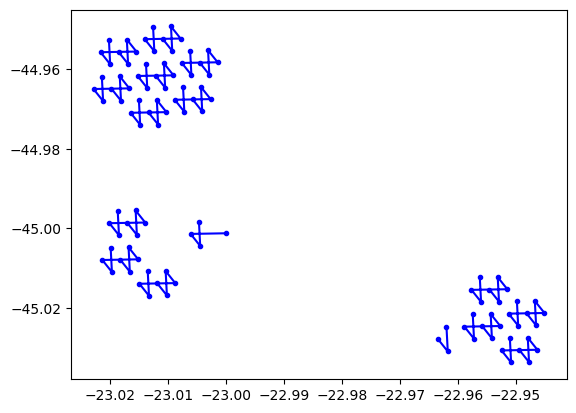

In [125]:
fig, ax = plt.subplots()

plot_x = np.array(cell_pt['lat'][:200])
plot_y = np.array(cell_pt['lng'][:200])
ax.plot(plot_x, plot_y, 'b.-')

In [126]:
cell_pt_nonull = cell_pt.dropna().sort_values(by=['h3int'])
cell_pt_nonull['index'] = cell_pt_nonull['h3int'].apply(lambda x: x//FACTOR)
cell_pt_nonull

,h3int,location,lat,lng,index
0,619959747913711615,"(-22.99993090639931, -45.001224845399896)",-22.999931,-45.001225,2364958755163
1,619959747913973759,"(-23.006117338935717, -45.001390166634984)",-23.006117,-45.001390,2364958755164
2,619959747914235903,"(-23.004461792111712, -45.00441415371622)",-23.004462,-45.004414,2364958755165
3,619959747914498047,"(-23.004679694968523, -44.99828350077068)",-23.004680,-44.998284,2364958755166
5,619959747915022335,"(-23.018270785589145, -45.00785156723498)",-23.018271,-45.007852,2364958755168
...,...,...,...,...,...
999994,619960010056138751,"(-24.182483729472803, -44.72871828064303)",-24.182484,-44.728718,2364959755157
999995,619960010056400895,"(-24.182693861287856, -44.722573178205145)",-24.182694,-44.722573,2364959755158
999997,619960010056925183,"(-24.174752491303447, -44.73158697852376)",-24.174752,-44.731587,2364959755160
999998,619960010057187327,"(-24.173121984356726, -44.73461868036009)",-24.173122,-44.734619,2364959755161


In [127]:
for col in ['lat', 'lng' ,'index']:
    cell_pt_nonull['diff_'+col] = cell_pt_nonull[col] - cell_pt_nonull[col].shift(1)
    cell_pt_nonull['prev_'+col] = cell_pt_nonull[col].shift(1)


In [128]:
cell_pt_nonull['diff_index'].value_counts()

1.0        381065
2.0         54438
10.0         7777
74.0         1111
586.0         158
4682.0         23
37450.0         4
Name: diff_index, dtype: int64

In [129]:
cell_pt_nonull

,h3int,location,lat,lng,index,diff_lat,prev_lat,diff_lng,prev_lng,diff_index,prev_index
0,619959747913711615,"(-22.99993090639931, -45.001224845399896)",-22.999931,-45.001225,2364958755163,NaN,NaN,NaN,NaN,NaN,NaN
1,619959747913973759,"(-23.006117338935717, -45.001390166634984)",-23.006117,-45.001390,2364958755164,-0.006186,-22.999931,-0.000165,-45.001225,1.0,2.364959e+12
2,619959747914235903,"(-23.004461792111712, -45.00441415371622)",-23.004462,-45.004414,2364958755165,0.001656,-23.006117,-0.003024,-45.001390,1.0,2.364959e+12
3,619959747914498047,"(-23.004679694968523, -44.99828350077068)",-23.004680,-44.998284,2364958755166,-0.000218,-23.004462,0.006131,-45.004414,1.0,2.364959e+12
5,619959747915022335,"(-23.018270785589145, -45.00785156723498)",-23.018271,-45.007852,2364958755168,-0.013591,-23.004680,-0.009568,-44.998284,2.0,2.364959e+12
...,...,...,...,...,...,...,...,...,...,...,...
999994,619960010056138751,"(-24.182483729472803, -44.72871828064303)",-24.182484,-44.728718,2364959755157,0.001630,-24.184114,-0.003032,-44.725686,1.0,2.364960e+12
999995,619960010056400895,"(-24.182693861287856, -44.722573178205145)",-24.182694,-44.722573,2364959755158,-0.000210,-24.182484,0.006145,-44.728718,1.0,2.364960e+12
999997,619960010056925183,"(-24.174752491303447, -44.73158697852376)",-24.174752,-44.731587,2364959755160,0.007941,-24.182694,-0.009014,-44.722573,2.0,2.364960e+12
999998,619960010057187327,"(-24.173121984356726, -44.73461868036009)",-24.173122,-44.734619,2364959755161,0.001631,-24.174752,-0.003032,-44.731587,1.0,2.364960e+12


In [130]:
cell_pt_nonull['distance'] = (
    2*6371*np.arcsin(np.sqrt(
        np.sin(cell_pt_nonull['diff_lat'] * np.pi/360)**2
        + np.cos(cell_pt_nonull['lat'] * np.pi/180)
        * np.cos(cell_pt_nonull['prev_lat'] * np.pi/180)
        * np.sin(cell_pt_nonull['diff_lng'] * np.pi/360)**2
    ))
)

<AxesSubplot: ylabel='Frequency'>

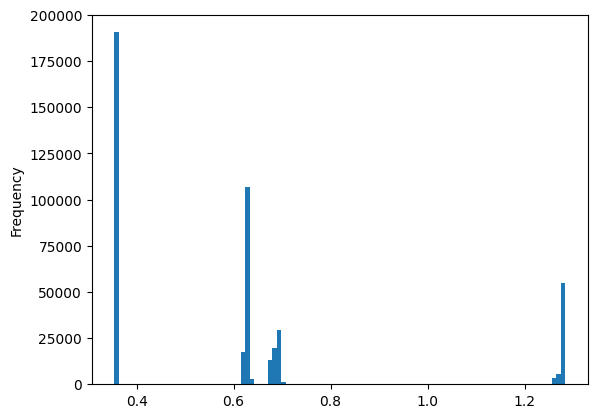

In [131]:
mx = cell_pt_nonull['distance'].quantile(0.90)
cell_pt_nonull['distance'].clip(upper=mx).plot.hist(bins=100)

In [132]:
series = cell_pt_nonull['distance'] / (REPORTED_EDGE * np.sqrt(3))
series.round(3).value_counts(normalize=True).sort_index().cumsum()

1.173      0.001426
1.174      0.009054
1.175      0.019389
1.176      0.029891
1.177      0.043252
             ...   
291.047    0.999991
559.826    0.999993
639.504    0.999996
640.443    0.999998
645.919    1.000000
Name: distance, Length: 2596, dtype: float64

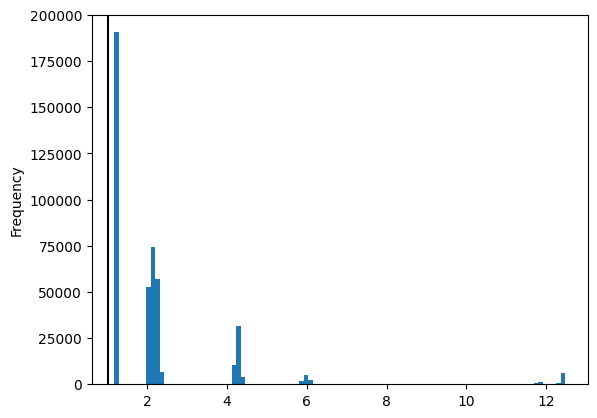

In [133]:
mx = series.quantile(0.99)
ax = series.clip(upper=mx).plot.hist(bins=100);
ax.axvline(1, color='k')

In [134]:
dff = pd.concat([series, cell_pt_nonull[['diff_index']]], axis=1).dropna()
dff

,distance,diff_index
1,2.278296,1.0
2,1.192334,1.0
3,2.079123,1.0
5,5.962351,2.0
6,1.192240,1.0
...,...,...
999994,1.181957,1.0
999995,2.065303,1.0
999997,4.208712,2.0
999998,1.182047,1.0


In [135]:
dff.groupby(['diff_index']).describe()

distance                                                 \
               count        mean        std         min         25%   
diff_index                                                            
1.0         381065.0    1.666565   0.483097    1.172861    1.188719   
2.0          54438.0    4.552827   0.640802    4.169078    4.235979   
10.0          7777.0   12.398190   0.565292   11.636044   11.836097   
74.0          1111.0   32.650584   5.066122   26.247611   26.638440   
586.0          158.0   87.753839   5.475930   79.248172   80.557931   
4682.0          23.0  228.735694  38.894853  180.506803  182.713689   
37450.0          4.0  621.423184  41.162209  559.825860  619.584794   

                                                
                   50%         75%         max  
diff_index                                      
1.0           2.057639    2.089329    2.317065  
2.0           4.280498    4.336791    6.078241  
10.0         12.441766   12.553446   13.671916  
74.0         33.776440   34.116059   41.867891  
586.0        91.036176   91.828189   93.440693  
4682.0      240.749029  243.097394  291.046584  
37450.0     639.973699  641.812089  645.919477

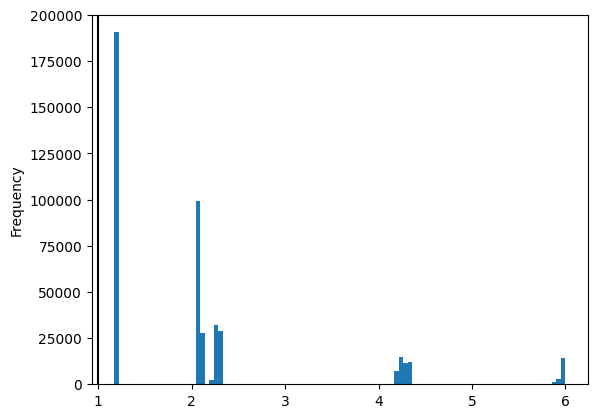

In [136]:
mx = 6
ax = series.clip(upper=mx).plot.hist(bins=100);
ax.axvline(1, color='k')

## With same endpoints


In [137]:
pts = [
    np.array(gosper_curve(Turtle(), order=order_, size=1, limit=1e6).history)
    for order_ in range(1, 9)
]

In [138]:
for x in pts:
    print(x[-1])

[2.5       0.8660254]
[5.5        4.33012702]
[10.         15.58845727]
[11.5        47.63139721]
[-12.5        129.03778516]
[-143.          311.76914536]
[-627.5         655.58123066]
[-2136.5         1095.52213579]


In [139]:
def scale_and_rotate(arr):
    angle = np.arctan2(arr[-1, 1], arr[-1, 0])
    cos, sin = np.cos(angle), np.sin(angle)
    mat = np.array([[cos, -sin], [sin, cos]])
    arr = np.dot(arr, mat)
    scale_ = arr[-1, 0]
    return arr / scale_


In [140]:
scale_and_rotate(pts[-3]).round(10)

array([[ 0.00000000e+00,  0.00000000e+00],
       [-1.21547990e-03, -2.64999400e-03],
       [ 4.71742200e-04, -5.02762750e-03],
       ...,
       [ 1.00411818e+00,  2.92235450e-03],
       [ 1.00290270e+00,  2.72360500e-04],
       [ 1.00000000e+00, -0.00000000e+00]])

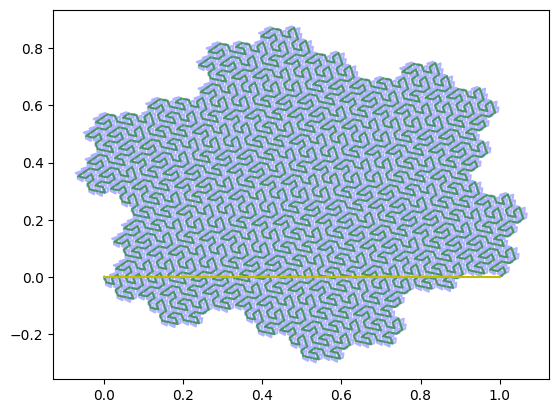

In [141]:
fig, ax = plt.subplots()
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for pt, color, alp in zip(pts[3:5][::-1], colors, [0.3, 0.6]):
    plot_pts = scale_and_rotate(pt)
    plot_x = np.array([x[0] for x in plot_pts])
    plot_y = np.array([x[1] for x in plot_pts])
    ax.plot(plot_x, plot_y, color+'-', alpha=alp);
ax.plot([0, 1], [0, 0], 'y-')

In [142]:
## Base cells

In [143]:
randpoints = np.random.random((1000000, 2))
randpoints[:, 0] = -90 + 180 * randpoints[:, 0]
randpoints[:, 1] = -180 + 360 * randpoints[:, 1]


In [144]:
randpoints

array([[ -86.94067264,  151.51333225],
       [ -40.32598858, -156.8921443 ],
       [  42.60760614,  146.59827679],
       ...,
       [  32.15695546,   33.04605016],
       [  -9.82946527, -135.48680306],
       [  39.01191447, -167.9504197 ]])

In [145]:
basecells_arr = [
    h3.geo_to_h3(x[0], x[1], 0)
    for x in randpoints
]

In [146]:
cts = collections.Counter(basecells_arr)

In [147]:
len(cts)

122

In [148]:
cts.most_common()

[('8003fffffffffff', 37987),
 ('80f1fffffffffff', 37949),
 ('80f3fffffffffff', 36906),
 ('8001fffffffffff', 36690),
 ('8005fffffffffff', 26647),
 ('80effffffffffff', 26536),
 ('80edfffffffffff', 15697),
 ('8007fffffffffff', 15359),
 ('800bfffffffffff', 13193),
 ('80e9fffffffffff', 13026),
 ('80e5fffffffffff', 12924),
 ('800ffffffffffff', 12615),
 ('800dfffffffffff', 12555),
 ('80e7fffffffffff', 12488),
 ('8011fffffffffff', 10588),
 ('80e3fffffffffff', 10440),
 ('80e1fffffffffff', 10333),
 ('8013fffffffffff', 10085),
 ('80ddfffffffffff', 10043),
 ('8017fffffffffff', 9927),
 ('80dffffffffffff', 9192),
 ('8021fffffffffff', 9133),
 ('8015fffffffffff', 9070),
 ('80d3fffffffffff', 8977),
 ('801bfffffffffff', 8868),
 ('80d9fffffffffff', 8820),
 ('80dbfffffffffff', 8518),
 ('8019fffffffffff', 8450),
 ('8027fffffffffff', 7900),
 ('801ffffffffffff', 7855),
 ('80d5fffffffffff', 7753),
 ('8035fffffffffff', 7622),
 ('80ebfffffffffff', 7616),
 ('80c1fffffffffff', 7593),
 ('80bffffffffffff', 7584),
 

In [149]:
boundaries = {
    x: h3.h3_to_geo_boundary(x)
    for x in cts.keys()
}
centers = {
    x: h3.h3_to_geo(x)
    for x in cts.keys()
}

In [150]:
collections.Counter([len(x) for x in boundaries.values()])

Counter({6: 110, 5: 12})

In [151]:
h3base = {}
for key in cts.keys():
    boundary_ = h3.h3_to_geo_boundary(key)
    center_ = h3.h3_to_geo(key)
    h3base[key] = {'center': tuple(center_), 'boundary': [tuple(x) for x in boundary_]}


In [152]:
dfcenters = pd.DataFrame(centers).T
dfcenters.columns = ['lat', 'lng']

In [153]:
dfp = dfcenters.assign(key=1).reset_index()
pairs = dfp.merge(dfp, on=['key'], suffixes=['_A', '_B'])
pairs

,index_A,lat_A,lng_A,key,index_B,lat_B,lng_B
0,80f3fffffffffff,-79.242399,-141.976593,1,80f3fffffffffff,-79.242399,-141.976593
1,80f3fffffffffff,-79.242399,-141.976593,1,80d5fffffffffff,-48.758350,-161.696956
2,80f3fffffffffff,-79.242399,-141.976593,1,802ffffffffffff,39.547653,143.635752
3,80f3fffffffffff,-79.242399,-141.976593,1,8025fffffffffff,44.985902,101.500692
4,80f3fffffffffff,-79.242399,-141.976593,1,80d9fffffffffff,-50.159757,135.390266
...,...,...,...,...,...,...,...
14879,80a1fffffffffff,-19.093681,-136.361181,1,8099fffffffffff,-14.029409,-7.421987
14880,80a1fffffffffff,-19.093681,-136.361181,1,80a5fffffffffff,-20.310286,-27.929099
14881,80a1fffffffffff,-19.093681,-136.361181,1,8065fffffffffff,9.897578,96.150734
14882,80a1fffffffffff,-19.093681,-136.361181,1,8089fffffffffff,-7.480115,-153.825359


In [154]:
import sklearn.metrics

In [155]:
help(sklearn.metrics.euclidean_distances)

Help on function euclidean_distances in module sklearn.metrics.pairwise:

euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)
    Compute the distance matrix between each pair from a vector array X and Y.
    
    For efficiency reasons, the euclidean distance between a pair of row
    vector x and y is computed as::
    
        dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    
    This formulation has two advantages over other ways of computing distances.
    First, it is computationally efficient when dealing with sparse data.
    Second, if one argument varies but the other remains unchanged, then
    `dot(x, x)` and/or `dot(y, y)` can be pre-computed.
    
    However, this is not the most precise way of doing this computation,
    because this equation potentially suffers from "catastrophic cancellation".
    Also, the distance matrix returned by this function may not be exactly
    symmetric as required by, e.g., ``scipy.spatial

In [156]:
deg_to_rad = np.pi / 180
vec = [
    np.cos(dfcenters['lat']*deg_to_rad) * np.cos(dfcenters['lng']*deg_to_rad),
    np.cos(dfcenters['lat']*deg_to_rad) * np.sin(dfcenters['lng']*deg_to_rad),
    np.sin(dfcenters['lat']*deg_to_rad)
]
vec = np.concatenate([x.values.reshape(-1, 1) for x in vec], axis=1)

In [157]:
vec.shape

(122, 3)

In [158]:
(vec**2).sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [159]:
ones = np.ones((vec.shape[0], 1))
euc = sklearn.metrics.euclidean_distances(X=vec, X_norm_squared=ones)
haversine = 2*1*np.arcsin(euc/2)

In [160]:
euc

array([[0.        , 0.53934466, 1.78145714, ..., 1.59120048, 1.1755705 ,
        1.00309123],
       [0.53934466, 0.        , 1.53934466, ..., 1.59120048, 0.71364418,
        0.61803399],
       [1.78145714, 1.53934466, 0.        , ..., 0.86858325, 1.20857575,
        1.47090811],
       ...,
       [1.59120048, 1.59120048, 0.86858325, ..., 0.        , 1.64731423,
        1.80154466],
       [1.1755705 , 0.71364418, 1.20857575, ..., 1.64731423, 0.        ,
        0.35682209],
       [1.00309123, 0.61803399, 1.47090811, ..., 1.80154466, 0.35682209,
        0.        ]])

In [161]:
haversine

array([[0.        , 0.54610548, 2.1978911 , ..., 1.83999544, 1.25663706,
        1.05076884],
       [0.54610548, 0.        , 1.75665552, ..., 1.83999544, 0.72972766,
        0.62831853],
       [2.1978911 , 1.75665552, 0.        , ..., 0.89850343, 1.29774359,
        1.65267311],
       ...,
       [1.83999544, 1.83999544, 0.89850343, ..., 0.        , 1.93566015,
        2.24308922],
       [1.25663706, 0.72972766, 1.29774359, ..., 1.93566015, 0.        ,
        0.3587427 ],
       [1.05076884, 0.62831853, 1.65267311, ..., 2.24308922, 0.3587427 ,
        0.        ]])

In [162]:
dists = [haversine[i][j] for i in range(len(haversine)) for j in range(len(haversine)) if i>j]

<AxesSubplot: ylabel='Frequency'>

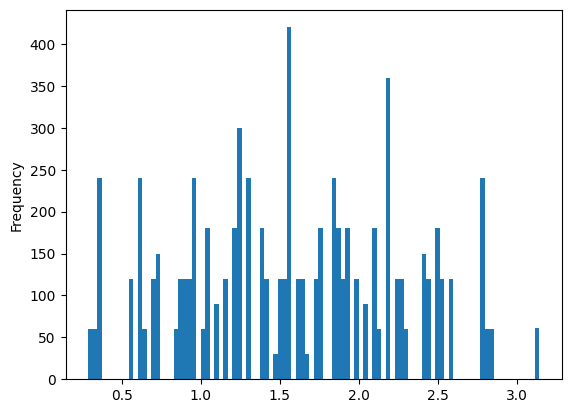

In [163]:
pd.Series(dists).plot.hist(bins=100)

In [164]:
122*121/2

7381.0

<AxesSubplot: ylabel='Frequency'>

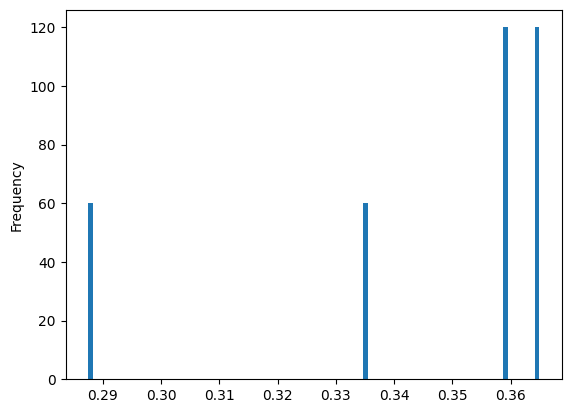

In [165]:
pd.Series([x for x in dists if x<0.5]).plot.hist(bins=100)

In [166]:
tops = [sorted(x) for x in haversine]

<AxesSubplot: ylabel='Frequency'>

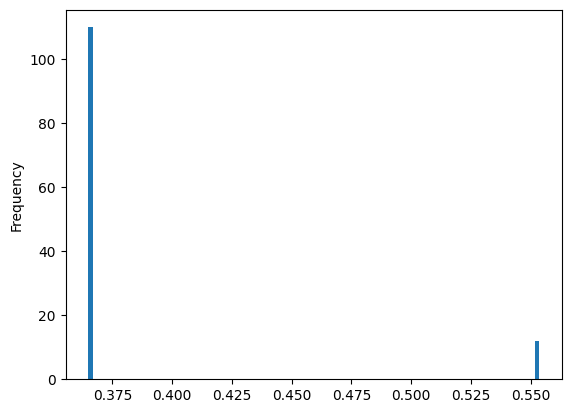

In [167]:
pd.Series([x[6] for x in tops]).plot.hist(bins=100)

In [168]:
collections.Counter([len([y for y in x if y<0.5]) for x in tops])

Counter({7: 110, 6: 12})

<AxesSubplot: ylabel='Frequency'>

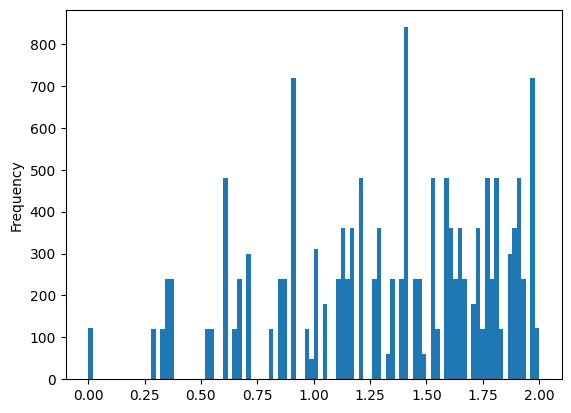

In [169]:
pd.Series([x for x in euc.flatten() if x<5555]).plot.hist(bins=100)

<AxesSubplot: ylabel='Frequency'>

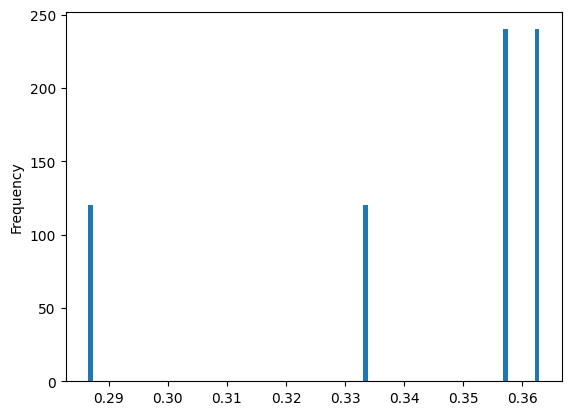

In [170]:
pd.Series([x for x in euc.flatten() if x<0.5 and x>=0.25]).plot.hist(bins=100)

In [171]:
collections.Counter([round(x, 5) for x in euc.flatten() if x<0.5 and x>=0.25])

Counter({0.35682: 240, 0.36284: 240, 0.33333: 120, 0.28651: 120})

In [172]:
tops_ = np.array(tops).round(5)

In [173]:
collections.Counter(tops_[:, 1])

Counter({0.28749: 72, 0.35874: 30, 0.36486: 20})

In [174]:
collections.Counter(tops_[:, 2])

Counter({0.3349: 60, 0.35874: 30, 0.36486: 20, 0.28749: 12})

In [175]:
collections.Counter(tops_[:, 3])

Counter({0.3349: 60, 0.35874: 30, 0.36486: 20, 0.28749: 12})

In [176]:
pattern = [tuple([round(y, 5) for y in x[1:7]]) for x in tops]

In [177]:
len(pattern)

122

In [178]:
collections.Counter(pattern).most_common()

[((0.28749, 0.3349, 0.3349, 0.35874, 0.35874, 0.36486), 60),
 ((0.35874, 0.35874, 0.35874, 0.35874, 0.36486, 0.36486), 30),
 ((0.36486, 0.36486, 0.36486, 0.36486, 0.36486, 0.36486), 20),
 ((0.28749, 0.28749, 0.28749, 0.28749, 0.28749, 0.55357), 12)]

In [179]:
pattern_dict = {
    x[0]: i
    for i, x in enumerate(
        collections.Counter(pattern).most_common()
    )
}
pattern_dict

{(0.28749, 0.3349, 0.3349, 0.35874, 0.35874, 0.36486): 0,
 (0.35874, 0.35874, 0.35874, 0.35874, 0.36486, 0.36486): 1,
 (0.36486, 0.36486, 0.36486, 0.36486, 0.36486, 0.36486): 2,
 (0.28749, 0.28749, 0.28749, 0.28749, 0.28749, 0.55357): 3}

In [180]:
import networkx as nx

In [181]:
graph = nx.Graph()
for key, pattern_ in zip(dfcenters.index, pattern):
    graph.add_node(key, pattern=pattern_dict[pattern_])

In [182]:
for i in range(len(haversine)):
    for j in range(len(haversine)):
        if (i>j) and (haversine[i,j] > 0) and (haversine[i,j] < 0.5):
            graph.add_edge(dfcenters.index[i], dfcenters.index[j], distance=haversine[i,j])

In [183]:
edges = []
for ed in graph.edges:
    edges.append({
        'nodes': ed,
        'distance': round(graph.edges[ed]['distance'], 5),
        'node_types': sorted([graph.nodes[x]['pattern'] for x in ed])
    })

In [184]:
len(edges) 

360

In [185]:
collections.Counter([tuple(x['node_types']) for x in edges])

Counter({(0, 1): 120, (0, 2): 60, (0, 0): 60, (0, 3): 60, (1, 2): 60})

In [186]:
pattern_dict

{(0.28749, 0.3349, 0.3349, 0.35874, 0.35874, 0.36486): 0,
 (0.35874, 0.35874, 0.35874, 0.35874, 0.36486, 0.36486): 1,
 (0.36486, 0.36486, 0.36486, 0.36486, 0.36486, 0.36486): 2,
 (0.28749, 0.28749, 0.28749, 0.28749, 0.28749, 0.55357): 3}

In [187]:
help(nx.draw)

Help on function draw in module networkx.drawing.nx_pylab:

draw(G, pos=None, ax=None, **kwds)
    Draw the graph G with Matplotlib.
    
    Draw the graph as a simple representation with no node
    labels or edge labels and using the full Matplotlib figure area
    and no axis labels by default.  See draw_networkx() for more
    full-featured drawing that allows title, axis labels etc.
    
    Parameters
    ----------
    G : graph
        A networkx graph
    
    pos : dictionary, optional
        A dictionary with nodes as keys and positions as values.
        If not specified a spring layout positioning will be computed.
        See :py:mod:`networkx.drawing.layout` for functions that
        compute node positions.
    
    ax : Matplotlib Axes object, optional
        Draw the graph in specified Matplotlib axes.
    
    kwds : optional keywords
        See networkx.draw_networkx() for a description of optional keywords.
    
    Examples
    --------
    >>> G = nx.dodecahe

In [188]:
help(nx.draw)

Help on function draw in module networkx.drawing.nx_pylab:

draw(G, pos=None, ax=None, **kwds)
    Draw the graph G with Matplotlib.
    
    Draw the graph as a simple representation with no node
    labels or edge labels and using the full Matplotlib figure area
    and no axis labels by default.  See draw_networkx() for more
    full-featured drawing that allows title, axis labels etc.
    
    Parameters
    ----------
    G : graph
        A networkx graph
    
    pos : dictionary, optional
        A dictionary with nodes as keys and positions as values.
        If not specified a spring layout positioning will be computed.
        See :py:mod:`networkx.drawing.layout` for functions that
        compute node positions.
    
    ax : Matplotlib Axes object, optional
        Draw the graph in specified Matplotlib axes.
    
    kwds : optional keywords
        See networkx.draw_networkx() for a description of optional keywords.
    
    Examples
    --------
    >>> G = nx.dodecahe

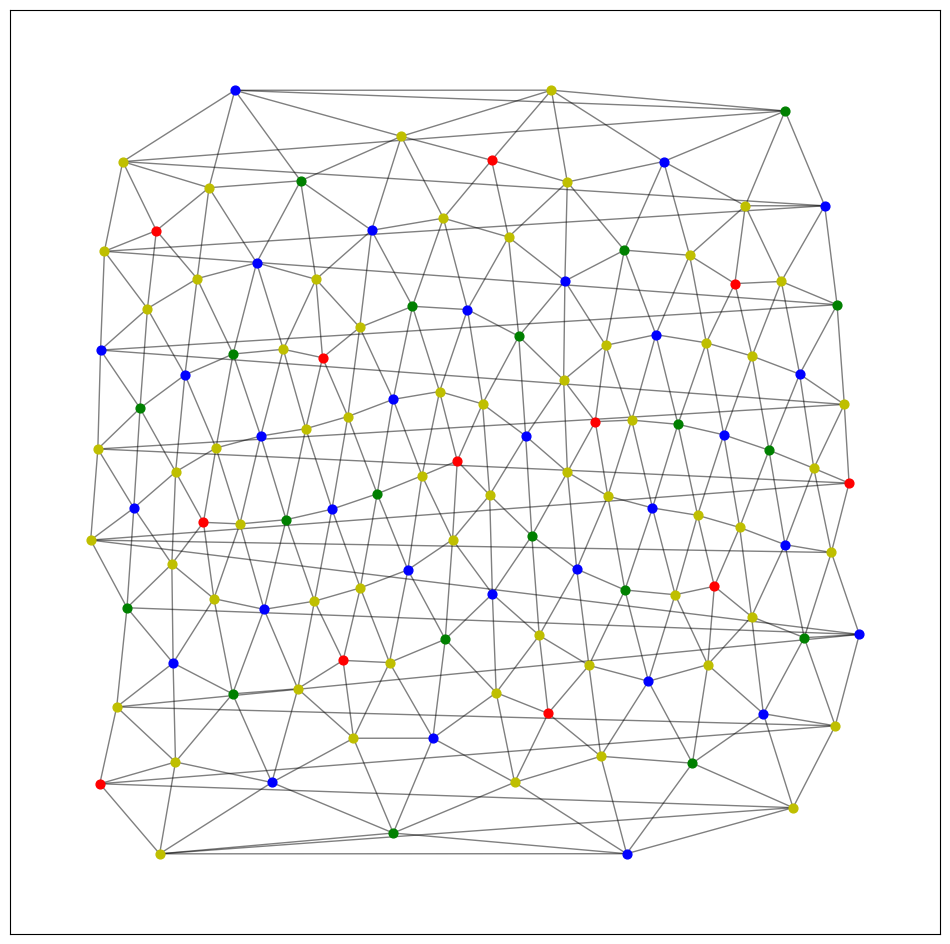

In [189]:
fig, ax = plt.subplots(figsize=(12, 12))
pos = {x: y[::-1] for x,y in centers.items()}
nx.draw_networkx_edges(graph, pos=pos, ax=ax, alpha=0.5)

nodes = [x for x in graph.nodes if graph.nodes[x]['pattern']==3]
nx.draw_networkx_nodes(graph.subgraph(nodes), pos=pos, ax=ax, node_size=40, node_color='r')

nodes = [x for x in graph.nodes if graph.nodes[x]['pattern']==0]
nx.draw_networkx_nodes(graph.subgraph(nodes), pos=pos, ax=ax, node_size=40, node_color='y')

nodes = [x for x in graph.nodes if graph.nodes[x]['pattern']==1]
nx.draw_networkx_nodes(graph.subgraph(nodes), pos=pos, ax=ax, node_size=40, node_color='b')

nodes = [x for x in graph.nodes if graph.nodes[x]['pattern']==2]
nx.draw_networkx_nodes(graph.subgraph(nodes), pos=pos, ax=ax, node_size=40, node_color='g')


In [190]:
collections.Counter([graph.nodes[x]['pattern'] for x in graph.nodes])

Counter({0: 60, 1: 30, 2: 20, 3: 12})

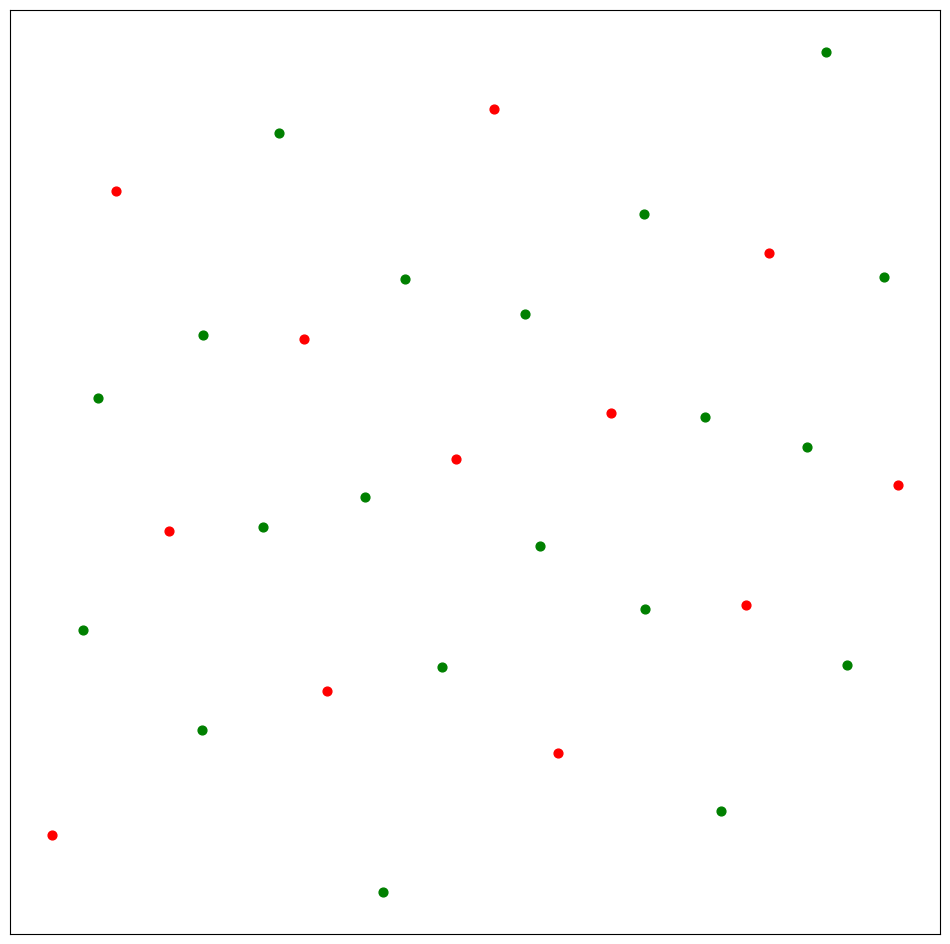

In [191]:
fig, ax = plt.subplots(figsize=(12, 12))
pos = {x: y[::-1] for x,y in centers.items()}

nodes = [x for x in graph.nodes if graph.nodes[x]['pattern']==3]
nx.draw_networkx_nodes(graph.subgraph(nodes), pos=pos, ax=ax, node_size=40, node_color='r')

# nodes = [x for x in graph.nodes if graph.nodes[x]['pattern']==0]
# nx.draw_networkx_nodes(graph.subgraph(nodes), pos=pos, ax=ax, node_size=40, node_color='y')

# nodes = [x for x in graph.nodes if graph.nodes[x]['pattern']==1]
# nx.draw_networkx_nodes(graph.subgraph(nodes), pos=pos, ax=ax, node_size=40, node_color='b')

nodes = [x for x in graph.nodes if graph.nodes[x]['pattern']==2]
nx.draw_networkx_nodes(graph.subgraph(nodes), pos=pos, ax=ax, node_size=40, node_color='g')


In [192]:
import folium
mapp = folium.Map()

nodes = [x for x in graph.nodes if graph.nodes[x]['pattern']==3]
for nd in nodes:
    folium.Marker(centers[nd]).add_to(mapp)

nodes = [x for x in graph.nodes if graph.nodes[x]['pattern']==2]
for nd in nodes:
    folium.Marker(centers[nd], icon=folium.Icon(color='green')).add_to(mapp)

In [193]:
mapp

In [194]:
haversine.shape

(122, 122)

In [195]:
haversine_dict = {
    (dfcenters.index[i], dfcenters.index[j]): haversine[i, j]
    for i in range(len(haversine)) for j in range(len(haversine))
}

In [196]:
nodes = [x for x in graph.nodes if graph.nodes[x]['pattern']==3]
haversine_dict_vert = {x: y for x, y in haversine_dict.items() if (x[0] in nodes) and (x[1] in nodes)}
ct = collections.Counter([round(x, 5) for x in haversine_dict_vert.values()]).most_common()
sorted(ct, key=lambda x: x[0])[:5]

[(0.0, 12), (1.10715, 60), (2.03444, 60), (3.14159, 12)]

In [197]:
nodes = [x for x in graph.nodes if graph.nodes[x]['pattern']==2]
haversine_dict_center = {x: y for x, y in haversine_dict.items() if (x[0] in nodes) and (x[1] in nodes)}
ct = collections.Counter([round(x, 5) for x in haversine_dict_center.values()]).most_common()
sorted(ct, key=lambda x: x[0])[:5]

[(0.0, 20), (0.72973, 60), (1.23096, 120), (1.91063, 120), (2.41186, 60)]

In [198]:
nodesA = [x for x in graph.nodes if graph.nodes[x]['pattern']==3]
nodesB = [x for x in graph.nodes if graph.nodes[x]['pattern']==2]
haversine_dict_centervert = {x: y for x, y in haversine_dict.items() if (x[0] in nodesA) and (x[1] in nodesB)}
ct = collections.Counter([round(x, 5) for x in haversine_dict_centervert.values()]).most_common()
sorted(ct, key=lambda x: x[0])[:5]

[(0.65236, 60), (1.38209, 60), (1.75951, 60), (2.48923, 60)]

In [199]:
graph2 = nx.Graph()
for edge_, dist_ in haversine_dict_centervert.items():
    if dist_ < 1:
        graph2.add_edge(*edge_)

In [200]:
len(graph2.nodes), len(graph2.edges)

(32, 60)

In [201]:
collections.Counter([nx.degree(graph2, x) for x in graph2.nodes])

Counter({5: 12, 3: 20})

In [202]:
faces_v0 = []
for nd in graph2.nodes:
    if nx.degree(graph2, nd) == 3:
        neighbors = list(nx.neighbors(graph2, nd))
        faces_v0.append({'center_id': nd, 'vertices_id': neighbors})
faces_v0

[{'center_id': '80e5fffffffffff',
  'vertices_id': ['80d7fffffffffff', '80ebfffffffffff', '80a7fffffffffff']},
 {'center_id': '80effffffffffff',
  'vertices_id': ['80d7fffffffffff', '80ebfffffffffff', '80c3fffffffffff']},
 {'center_id': '80c1fffffffffff',
  'vertices_id': ['80d7fffffffffff', '80c3fffffffffff', '8075fffffffffff']},
 {'center_id': '80abfffffffffff',
  'vertices_id': ['80d7fffffffffff', '80a7fffffffffff', '8063fffffffffff']},
 {'center_id': '8097fffffffffff',
  'vertices_id': ['80d7fffffffffff', '8075fffffffffff', '8063fffffffffff']},
 {'center_id': '8005fffffffffff',
  'vertices_id': ['8031fffffffffff', '801dfffffffffff', '8009fffffffffff']},
 {'center_id': '8021fffffffffff',
  'vertices_id': ['8031fffffffffff', '8009fffffffffff', '8063fffffffffff']},
 {'center_id': '8073fffffffffff',
  'vertices_id': ['8031fffffffffff', '807ffffffffffff', '80a7fffffffffff']},
 {'center_id': '8033fffffffffff',
  'vertices_id': ['8031fffffffffff', '801dfffffffffff', '807ffffffffffff']},
 

In [203]:
import shapely

faces_v1 = [
    {
        'type': 'Feature',
        'geometry': shapely.geometry.shape({
            'type': 'Polygon',
            'coordinates': [[centers[x][::-1] for x in row['vertices_id']]],
        }).simplify(0).__geo_interface__,
        'properties': {
            'center_id': row['center_id'],
            'center_location': centers[row['center_id']][::-1],
            'vertices_id': row['vertices_id']
        }

    }
    for row in faces_v0
]

In [204]:
faces_v1

[{'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': (((36.52150998497483, -50.10320148224133),
     (-169.46380092453236, -64.7000001279349),
     (112.86767363356435, -23.71792527122296),
     (36.52150998497483, -50.10320148224133)),)},
  'properties': {'center_id': '80e5fffffffffff',
   'center_location': (102.79294251439185, -60.43279526305555),
   'vertices_id': ['80d7fffffffffff', '80ebfffffffffff', '80a7fffffffffff']}},
 {'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': (((36.52150998497483, -50.10320148224133),
     (-169.46380092453236, -64.7000001279349),
     (-57.69999959221297, -39.10000003397591),
     (36.52150998497483, -50.10320148224133)),)},
  'properties': {'center_id': '80effffffffffff',
   'center_location': (-34.64375807722018, -74.92843438917433),
   'vertices_id': ['80d7fffffffffff', '80ebfffffffffff', '80c3fffffffffff']}},
 {'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'coordinates': (((36.52150998497483, -

In [205]:
geo_base_cells = [
    {
        'type': 'Feature',
        'geometry': shapely.geometry.shape({
            'type': 'Polygon',
            'coordinates': [[x[::-1] for x in boundaries[nd]]],
        }).simplify(0).__geo_interface__,
    }
    for nd in graph.nodes
]

In [206]:
mapp = folium.Map()
folium.GeoJson(
    {'type': 'FeatureCollection', 'features': faces_v1},
    style_function=lambda x: {'color': 'green', 'fillOpacity': 0.2, 'weight': 1}
).add_to(mapp)
folium.GeoJson(
    {'type': 'FeatureCollection', 'features': geo_base_cells},
    style_function=lambda x: {'color': 'blue', 'fillOpacity': 0.2, 'weight': 1}
).add_to(mapp)

mapp

In [207]:
def needed_rotations(vertices, center):
    centers_ = np.array([centers[x] for x in vertices+[center]])
    vec = [
        np.cos(centers_[:, 0]*deg_to_rad) * np.cos(centers_[:, 1]*deg_to_rad),
        np.cos(centers_[:, 0]*deg_to_rad) * np.sin(centers_[:, 1]*deg_to_rad),
        np.sin(centers_[:, 0]*deg_to_rad)
    ]
    vec = np.concatenate([x.reshape(-1, 1) for x in vec], axis=1)
    
    angle_rot_z1 = 1 * np.arctan2(vec[-1, 1], vec[-1, 0])
    cos, sin = np.cos(angle_rot_z1), np.sin(angle_rot_z1)
    matrix_rot_z1 = np.array([[cos, -sin, 0], [sin, cos, 0], [0,0,1]])
    vec = np.dot(vec, matrix_rot_z1)

    angle_rot_y = 1 * np.arctan2(vec[-1, 0], vec[-1, 2])
    cos, sin = np.cos(angle_rot_y), np.sin(angle_rot_y)
    matrix_rot_y = np.array([[cos, 0, sin], [0,1,0], [-sin, 0, cos]])
    vec = np.dot(vec, matrix_rot_y)

    angle_rot_z2 = 1 * np.arctan2(vec[-2, 1], vec[-2, 0])
    cos, sin = np.cos(angle_rot_z2), np.sin(angle_rot_z2)
    matrix_rot_z2 = np.array([[cos, -sin, 0], [sin, cos, 0], [0,0,1]])
    vec = np.dot(vec, matrix_rot_z2)

    rotation = np.dot(np.dot(matrix_rot_z1, matrix_rot_y), matrix_rot_z2)

    return vec.round(5), rotation

In [208]:
rot = needed_rotations(faces_v0[0]['vertices_id'], faces_v0[0]['center_id'])
rot

(array([[-0.30353,  0.52573,  0.79465],
        [-0.30353, -0.52573,  0.79465],
        [ 0.60706, -0.     ,  0.79465],
        [-0.     , -0.     ,  1.     ]]),
 array([[-0.44304445,  0.88981645, -0.10926253],
        [ 0.75971832,  0.43735489,  0.48119516],
        [ 0.47596187,  0.1301821 , -0.86977751]]))

In [209]:
np.arctan2(rot[0][-2, 2], np.sqrt(rot[0][-2, 0]**2 + rot[0][-2, 1]**2)) * 180/np.pi

52.62256728243063

In [210]:
print(np.arctan2(rot[0][0, 1], rot[0][0, 0])* 180/np.pi)
print(np.arctan2(rot[0][1, 1], rot[0][1, 0])* 180/np.pi)
print(np.arctan2(rot[0][2, 1], rot[0][2, 0])* 180/np.pi)
print(np.arctan2(rot[0][3, 1], rot[0][3, 0])* 180/np.pi)


119.99997081799681
-119.99997081799681
-0.0
-180.0


In [211]:
len(faces_v0)

20

In [212]:
faces_v0[0]

{'center_id': '80e5fffffffffff',
 'vertices_id': ['80d7fffffffffff', '80ebfffffffffff', '80a7fffffffffff']}

In [213]:
vertices = set()
faces_ = set()
for f in faces_v0:
    vertices = vertices.union(set(f['vertices_id']))
    faces_ = faces_.union(set([f['center_id']]))
len(vertices), len(faces_)

(12, 20)

In [214]:
coord_interest_points = np.array([h3.h3_to_geo(x) for x in sorted(vertices) + sorted(faces_)])
coord_interest_points

array([[  64.70000013,   10.53619908],
       [  50.10320148, -143.47849002],
       [  39.10000003,  122.30000041],
       [  23.71792527,  -67.13232637],
       [  10.44734519,   58.15770584],
       [   2.30088211,   -5.2453903 ],
       [  -2.30088211,  174.7546097 ],
       [ -10.44734519, -121.84229416],
       [ -23.71792527,  112.86767363],
       [ -39.10000003,  -57.69999959],
       [ -50.10320148,   36.52150998],
       [ -64.70000013, -169.46380092],
       [  74.92843439,  145.35624192],
       [  60.43279526,  -77.20705749],
       [  46.04189432,   71.5279033 ],
       [  34.71719281,  169.2473398 ],
       [  34.38844532,  -25.81770224],
       [  28.17321876,   23.03222744],
       [  24.48652699, -108.2246343 ],
       [  13.23312746, -150.9799405 ],
       [   9.89757819,   96.15073393],
       [   4.5301549 ,  137.97758431],
       [  -4.5301549 ,  -42.02241569],
       [  -9.89757819,  -83.84926607],
       [ -13.23312746,   29.0200595 ],
       [ -24.48652699,   

In [215]:
deg_to_rad = np.pi/180
arr_vertices = np.concatenate([
    (np.cos(coord_interest_points[:, 0]*deg_to_rad) * np.cos(coord_interest_points[:, 1]*deg_to_rad)).reshape(-1, 1),
    (np.cos(coord_interest_points[:, 0]*deg_to_rad) * np.sin(coord_interest_points[:, 1]*deg_to_rad)).reshape(-1, 1),
    (np.sin(coord_interest_points[:, 0]*deg_to_rad)).reshape(-1, 1)
], axis=1)
arr_vertices

array([[ 0.42015243,  0.07814525,  0.90408255],
       [-0.51545596, -0.3817169 ,  0.76720099],
       [-0.41468223,  0.65596241,  0.63067581],
       [ 0.3557814 , -0.84358   ,  0.40223423],
       [ 0.51883673,  0.83542038,  0.18133184],
       [ 0.99500944, -0.0913478 ,  0.04014718],
       [-0.99500944,  0.0913478 , -0.04014718],
       [-0.51883673, -0.83542038, -0.18133184],
       [-0.3557814 ,  0.84358   , -0.40223423],
       [ 0.41468223, -0.65596241, -0.63067581],
       [ 0.51545596,  0.3817169 , -0.76720099],
       [-0.42015243, -0.07814525, -0.90408255],
       [-0.21392348,  0.14781718,  0.96560179],
       [ 0.10926253, -0.48119516,  0.86977751],
       [ 0.21993078,  0.65836918,  0.71984754],
       [-0.80754076,  0.15335525,  0.5695262 ],
       [ 0.74285673, -0.35939417,  0.56480059],
       [ 0.81125347,  0.34489532,  0.47213877],
       [-0.28461481, -0.8644081 ,  0.41447926],
       [-0.8512304 , -0.47223438,  0.22891374],
       [-0.10554981,  0.97944573,  0.171

In [216]:
def rotation_matrix(north_pole_array, extra_rotation):
    vec = north_pole_array.copy()
    
    angle_rot_z1 = 1 * np.arctan2(vec[1], vec[0])
    cos, sin = np.cos(angle_rot_z1), np.sin(angle_rot_z1)
    matrix_rot_z1 = np.array([[cos, -sin, 0], [sin, cos, 0], [0,0,1]])
    vec = np.dot(vec, matrix_rot_z1)

    angle_rot_y = 1 * np.arctan2(vec[0], vec[2])
    cos, sin = np.cos(angle_rot_y), np.sin(angle_rot_y)
    matrix_rot_y = np.array([[cos, 0, sin], [0,1,0], [-sin, 0, cos]])
    vec = np.dot(vec, matrix_rot_y)

    angle_rot_z2 = extra_rotation
    cos, sin = np.cos(angle_rot_z2), np.sin(angle_rot_z2)
    matrix_rot_z2 = np.array([[cos, -sin, 0], [sin, cos, 0], [0,0,1]])
    vec = np.dot(vec, matrix_rot_z2)

    rotation = np.dot(np.dot(matrix_rot_z1, matrix_rot_y), matrix_rot_z2)

    return vec.round(5), rotation

In [217]:
new_vertices = arr_vertices.copy().round(12)
_, matA = rotation_matrix(new_vertices[0, :], 0)
new_vertices = np.dot(new_vertices, matA).round(12)
_, matB = rotation_matrix(new_vertices[0, :], 1 * np.arctan2(new_vertices[1, 1], new_vertices[1, 0]))
new_vertices = np.dot(new_vertices, matB).round(12)
print(new_vertices.shape)
new_vertices.round(5)

(32, 3)


array([[ 0.     ,  0.     ,  1.     ],
       [ 0.89443, -0.     ,  0.44721],
       [ 0.27639, -0.85065,  0.44721],
       [ 0.27639,  0.85065,  0.44721],
       [-0.72361, -0.52573,  0.44721],
       [-0.72361,  0.52573,  0.44721],
       [ 0.72361, -0.52573, -0.44721],
       [ 0.72361,  0.52573, -0.44721],
       [-0.27639, -0.85065, -0.44721],
       [-0.27639,  0.85065, -0.44721],
       [-0.89443,  0.     , -0.44721],
       [ 0.     ,  0.     , -1.     ],
       [ 0.49112, -0.35682,  0.79465],
       [ 0.49112,  0.35682,  0.79465],
       [-0.18759, -0.57735,  0.79465],
       [ 0.79465, -0.57735,  0.18759],
       [-0.18759,  0.57735,  0.79465],
       [-0.60706, -0.     ,  0.79465],
       [ 0.79465,  0.57735,  0.18759],
       [ 0.98225, -0.     , -0.18759],
       [-0.30353, -0.93417,  0.18759],
       [ 0.30353, -0.93417, -0.18759],
       [-0.30353,  0.93417,  0.18759],
       [ 0.30353,  0.93417, -0.18759],
       [-0.98225,  0.     ,  0.18759],
       [-0.79465, -0.5773

In [218]:
new_coord_vertices = np.concatenate([
    (np.arctan2(new_vertices[:, 2], np.sqrt(new_vertices[:, 0]**2 + new_vertices[:, 1]**2))).reshape(-1, 1),
    (np.arctan2(new_vertices[:, 1], new_vertices[:, 0])).reshape(-1, 1)
], axis=1)
new_coord_vertices * 180 / np.pi

array([[  90.        ,    0.        ],
       [  26.56505118,   -0.        ],
       [  26.56505118,  -72.        ],
       [  26.56505118,   72.        ],
       [  26.56505118, -144.        ],
       [  26.56505118,  144.        ],
       [ -26.56505118,  -36.        ],
       [ -26.56505118,   36.        ],
       [ -26.56505118, -108.        ],
       [ -26.56505118,  108.        ],
       [ -26.56505118,  180.        ],
       [ -90.        ,    0.        ],
       [  52.62263186,  -36.        ],
       [  52.62263186,   36.        ],
       [  52.62263186, -108.        ],
       [  10.81231696,  -36.        ],
       [  52.62263186,  108.        ],
       [  52.62263186, -180.        ],
       [  10.81231696,   36.        ],
       [ -10.81231696,   -0.        ],
       [  10.81231696, -108.        ],
       [ -10.81231696,  -72.        ],
       [  10.81231696,  108.        ],
       [ -10.81231696,   72.        ],
       [  10.81231696,  180.        ],
       [ -10.81231696, -1

In [219]:
mapp = folium.Map()
for row in new_coord_vertices[1:11] * 180 / np.pi:
    folium.Marker(tuple(row), icon=folium.Icon(color='blue')).add_to(mapp)
for row in new_coord_vertices[12:] * 180 / np.pi:
    folium.Marker(tuple(row), icon=folium.Icon(color='green')).add_to(mapp)
mapp


In [220]:
mapp = folium.Map()
for row in new_coord_vertices[1:11] * 180 / np.pi:
    folium.Marker(tuple(row), icon=folium.Icon(color='blue')).add_to(mapp)
# for row in new_coord_vertices[12:] * 180 / np.pi:
#     folium.Marker(tuple(row), icon=folium.Icon(color='green')).add_to(mapp)
mapp

In [221]:
new_coord_vertices_deg = new_coord_vertices * 180 / np.pi

In [222]:
collections.Counter(new_coord_vertices_deg[:12, 0].round(5))

Counter({90.0: 1, 26.56505: 5, -26.56505: 5, -90.0: 1})

In [223]:
collections.Counter(new_coord_vertices_deg[12:, 0].round(5))

Counter({52.62263: 5, 10.81232: 5, -10.81232: 5, -52.62263: 5})

In [224]:
collections.Counter(new_coord_vertices_deg[:12, 1].round(5))

Counter({0.0: 3,
         -72.0: 1,
         72.0: 1,
         -144.0: 1,
         144.0: 1,
         -36.0: 1,
         36.0: 1,
         -108.0: 1,
         108.0: 1,
         180.0: 1})

In [225]:
sorted(collections.Counter(new_coord_vertices_deg[12:, 1].round(5)).most_common())

[(-180.0, 1),
 (-144.0, 2),
 (-108.0, 2),
 (-72.0, 2),
 (-36.0, 2),
 (-0.0, 2),
 (36.0, 2),
 (72.0, 2),
 (108.0, 2),
 (144.0, 2),
 (180.0, 1)]

Finding a set of points which are closest to vertices?

In [226]:
vertices_ = np.array(sorted(new_vertices[:12, :].copy(), key=lambda x: (-x[2], x[1])))
vertices_

array([[ 0.        ,  0.        ,  1.        ],
       [ 0.2763932 , -0.85065081,  0.4472136 ],
       [-0.7236068 , -0.52573111,  0.4472136 ],
       [ 0.89442719, -0.        ,  0.4472136 ],
       [-0.7236068 ,  0.52573111,  0.4472136 ],
       [ 0.2763932 ,  0.85065081,  0.4472136 ],
       [-0.2763932 , -0.85065081, -0.4472136 ],
       [ 0.7236068 , -0.52573111, -0.4472136 ],
       [-0.89442719,  0.        , -0.4472136 ],
       [ 0.7236068 ,  0.52573111, -0.4472136 ],
       [-0.2763932 ,  0.85065081, -0.4472136 ],
       [ 0.        ,  0.        , -1.        ]])

In [227]:
random_points = np.random.randn(10000, 3)
norm_ = (random_points**2).sum(axis=1).reshape(-1, 1)
random_points = random_points / np.sqrt(norm_)

In [228]:
dist = sklearn.metrics.euclidean_distances(random_points, vertices_)

In [229]:
dist.shape

(10000, 12)

In [230]:
closest = np.argsort(dist, axis=1)[:, :3]
closest.shape

(10000, 3)

In [231]:
closest_tuples = [tuple(sorted(x)) for x in closest]

In [232]:
ct = collections.Counter(closest_tuples).most_common()
sorted(ct)

[((0, 1, 2), 519),
 ((0, 1, 3), 517),
 ((0, 2, 4), 473),
 ((0, 3, 5), 510),
 ((0, 4, 5), 484),
 ((1, 2, 6), 464),
 ((1, 3, 7), 502),
 ((1, 6, 7), 529),
 ((2, 4, 8), 460),
 ((2, 6, 8), 530),
 ((3, 5, 9), 471),
 ((3, 7, 9), 498),
 ((4, 5, 10), 485),
 ((4, 8, 10), 530),
 ((5, 9, 10), 504),
 ((6, 7, 11), 514),
 ((6, 8, 11), 516),
 ((7, 9, 11), 500),
 ((8, 10, 11), 465),
 ((9, 10, 11), 529)]

In [233]:
plot_pts = np.concatenate([
    (np.arctan2(vertices_[:, 2], np.sqrt(vertices_[:, 0]**2 + vertices_[:, 1]**2))).reshape(-1, 1),
    (np.arctan2(vertices_[:, 1], vertices_[:, 0])).reshape(-1, 1)
], axis=1)
mapp = folium.Map()
for j, row in enumerate(plot_pts * 180 / np.pi):
    folium.Marker(tuple(row), icon=folium.Icon(color='blue'), popup=str(j)).add_to(mapp)
mapp

In [234]:
mapp = folium.Map()
plot_pts = np.concatenate([
    (np.arctan2(vertices_[:, 2], np.sqrt(vertices_[:, 0]**2 + vertices_[:, 1]**2))).reshape(-1, 1),
    (np.arctan2(vertices_[:, 1], vertices_[:, 0])).reshape(-1, 1)
], axis=1)
for j, row in enumerate(plot_pts * 180 / np.pi):
    folium.Marker(tuple(row), icon=folium.Icon(color='blue'), popup=str(j)).add_to(mapp)

plot_pts = random_points[[x==(1,3,7) for x in closest_tuples]]
plot_pts = np.concatenate([
    (np.arctan2(plot_pts[:, 2], np.sqrt(plot_pts[:, 0]**2 + plot_pts[:, 1]**2))).reshape(-1, 1),
    (np.arctan2(plot_pts[:, 1], plot_pts[:, 0])).reshape(-1, 1)
], axis=1)
for j, row in enumerate(plot_pts * 180 / np.pi):
    folium.Marker(tuple(row), icon=folium.Icon(color='green')).add_to(mapp)

mapp

In [235]:
plot_pts.shape

(502, 2)

In [236]:
def get_rotation_matrix(array_to_z, array_to_x):
    vec0 = array_to_z
    vec0 = vec0 / np.sqrt((vec0**2).sum())    
    inner_product = np.dot(vec0, array_to_x)
    vec1 = array_to_x - inner_product * vec0
    vec1 = vec1 / np.sqrt((vec1**2).sum())
    vec2 = np.array([
        vec0[1]*vec1[2]-vec0[2]*vec1[1],
        vec0[2]*vec1[0]-vec0[0]*vec1[2],
        vec0[0]*vec1[1]-vec0[1]*vec1[0],
    ])
    matrix = np.concatenate([
        vec1.reshape(-1, 1),
        vec2.reshape(-1, 1),
        vec0.reshape(-1, 1),
    ], axis=1)
    return matrix

In [237]:
mat = get_rotation_matrix(arr_vertices[0], arr_vertices[1])
np.dot(arr_vertices, mat).round(10)

array([[-0.        ,  0.        ,  1.        ],
       [ 0.89442719,  0.        ,  0.4472136 ],
       [ 0.2763932 , -0.85065081,  0.4472136 ],
       [ 0.2763932 ,  0.85065081,  0.4472136 ],
       [-0.7236068 , -0.52573111,  0.4472136 ],
       [-0.7236068 ,  0.52573111,  0.4472136 ],
       [ 0.7236068 , -0.52573111, -0.4472136 ],
       [ 0.7236068 ,  0.52573111, -0.4472136 ],
       [-0.2763932 , -0.85065081, -0.4472136 ],
       [-0.2763932 ,  0.85065081, -0.4472136 ],
       [-0.89442719,  0.        , -0.4472136 ],
       [-0.        , -0.        , -1.        ],
       [ 0.49112347, -0.35682209,  0.79465447],
       [ 0.49112347,  0.35682209,  0.79465447],
       [-0.18759247, -0.57735027,  0.79465447],
       [ 0.79465447, -0.57735027,  0.18759247],
       [-0.18759247,  0.57735027,  0.79465447],
       [-0.607062  ,  0.        ,  0.79465447],
       [ 0.79465447,  0.57735027,  0.18759247],
       [ 0.98224695, -0.        , -0.18759247],
       [-0.303531  , -0.93417236,  0.187

In [238]:
mat = get_rotation_matrix(arr_vertices[12], arr_vertices[0])
v = np.dot(arr_vertices, mat).round(10)

In [239]:
v[12]

array([ 0., -0.,  1.])

In [240]:
a = sorted(v[:12], key=lambda x: -np.dot(x, v[12]))
a

[array([0.607062  , 0.        , 0.79465447]),
 array([-0.303531  , -0.52573111,  0.79465447]),
 array([-0.303531  ,  0.52573111,  0.79465447]),
 array([ 0.49112347, -0.85065081,  0.18759247]),
 array([0.49112347, 0.85065081, 0.18759247]),
 array([-0.98224695,  0.        ,  0.18759247]),
 array([ 0.98224695, -0.        , -0.18759247]),
 array([-0.49112347, -0.85065081, -0.18759247]),
 array([-0.49112347,  0.85065081, -0.18759247]),
 array([ 0.303531  , -0.52573111, -0.79465447]),
 array([ 0.303531  ,  0.52573111, -0.79465447]),
 array([-0.607062  ,  0.        , -0.79465447])]

In [241]:
print(np.arctan2(a[0][1], a[0][0]) * 180/np.pi)
print(np.arctan2(a[1][1], a[1][0]) * 180/np.pi)
print(np.arctan2(a[2][1], a[2][0]) * 180/np.pi)
print(np.arctan2(a[0][2], np.sqrt(a[0][0]**2+a[0][1]**2)) * 180/np.pi)

0.0
-120.0000000006297
120.0000000006297
52.62263185994112


In [242]:
np.arcsin(a[0][2])* 180/np.pi

52.622631860127434

In [243]:
sin_ = a[0][2]
bb = np.sqrt(1-sin_**2) / sin_
bb

0.7639320224787314

In [244]:
bb/2 * np.sqrt(3)

0.6615845382310062